In [70]:
# List of things in this notebook 
# 5 juillet, mise a jour, redid seeds with x_correl + averaged fc maps NOT concatenated 
# classification
# logistic regression
# MLG 
# VIOLIN PLOT 

In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

In [2]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
0     100206          27   True    NotTwin                   56037_85858   
1     100610          27   True      NotMZ         DZ        52813_82634   
2     101006          35   True         MZ             51283_52850_81149   
3     101309          29   True    NotTwin                   52385_82248   
4     102008          24   True    NotTwin                   52018_81882   
..       ...         ...    ...        ...        ...                ...   
669   990366          22   True         MZ                   56064_85885   
670   991267          30   True    NotTwin                   51639_81503   
671   992673          33   True    NotTwin                   56143_85963   
672   993675          29   True    NotTwin                   55800_85621   
673   996782          28   True      NotMZ         DZ        51541_81405   

     Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
0        56037      85858                 NaN                 White  ...   
1        52813      82634                 NaN                 White  ...   
2        51283      81149                 NaN  Black or African Am.  ...   
3        52385      82248                 NaN  Black or African Am.  ...   
4        52018      81882                 NaN                 White  ...   
..         ...        ...                 ...                   ...  ...   
669      56064      85885                 NaN                 White  ...   
670      51639      81503                 NaN                 White  ...   
671      56143      85963                 NaN                 White  ...   
672      55800      85621                 NaN                 White  ...   
673      51541      81405                 NaN                 White  ...   

    Noise_Comp  Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0      108.79        97.19                  1.0   
1          2.0      122.25       110.45                  0.0   
2          6.0      122.25       111.41                  0.0   
3          5.2      122.25       110.45                  0.0   
4          6.0      122.25       110.45                  0.0   
..         ...         ...          ...                  ...   
669        4.4      108.79        97.19                  1.0   
670        2.8      122.25       111.41                  1.0   
671        3.6      122.25       111.41                  1.0   
672        0.4      122.25       110.45                  0.0   
673        6.0      108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 38.6       106.39        104.39            1.80        0.0   
4                 50.1        67.48         65.31            1.80        0.0   
..                 ...          ...           ...             ...        ...   
669               52.6        93.82         92.63            1.80        0.0   
670               46.6        83.23         81.55            1.84        0.0   
671               38.6       101.63         99.26            1.80        0.0   
672               38.6        84.07         84.25            1.80        1.0   
673               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.80  
..          ...  
669        1.80  
670        1.84  
671        1.80  
672        1.76  
673        1.84  

[674 rows x 583 columns]

In [3]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

index  subject_label  Age_in_Yrs  HasGT ZygositySR ZygosityGT  \
0        0         100206          27   True    NotTwin              
1        1         100610          27   True      NotMZ         DZ   
2        2         101006          35   True         MZ              
3        4         102008          24   True    NotTwin              
4        7         102513          30   True    NotTwin              
..     ...            ...         ...    ...        ...        ...   
565    669         990366          22   True         MZ              
566    670         991267          30   True    NotTwin              
567    671         992673          33   True    NotTwin              
568    672         993675          29   True    NotTwin              
569    673         996782          28   True      NotMZ         DZ   

             Family_ID  Mother_ID  Father_ID  TestRetestInterval  ...  \
0          56037_85858      56037      85858                 NaN  ...   
1          52813_82634      52813      82634                 NaN  ...   
2    51283_52850_81149      51283      81149                 NaN  ...   
3          52018_81882      52018      81882                 NaN  ...   
4          56077_85897      56077      85897                 NaN  ...   
..                 ...        ...        ...                 ...  ...   
565        56064_85885      56064      85885                 NaN  ...   
566        51639_81503      51639      81503                 NaN  ...   
567        56143_85963      56143      85963                 NaN  ...   
568        55800_85621      55800      85621                 NaN  ...   
569        51541_81405      51541      81405                 NaN  ...   

    Noise_Comp Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0     108.79        97.19                  1.0   
1          2.0     122.25       110.45                  0.0   
2          6.0     122.25       111.41                  0.0   
3          6.0     122.25       110.45                  0.0   
4          5.2     108.79        98.04                  2.0   
..         ...        ...          ...                  ...   
565        4.4     108.79        97.19                  1.0   
566        2.8     122.25       111.41                  1.0   
567        3.6     122.25       111.41                  1.0   
568        0.4     122.25       110.45                  0.0   
569        6.0     108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 50.1        67.48         65.31            1.80        0.0   
4                 54.3        84.07         82.37            1.92        0.0   
..                 ...          ...           ...             ...        ...   
565               52.6        93.82         92.63            1.80        0.0   
566               46.6        83.23         81.55            1.84        0.0   
567               38.6       101.63         99.26            1.80        0.0   
568               38.6        84.07         84.25            1.80        1.0   
569               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.92  
..          ...  
565        1.80  
566        1.84  
567        1.80  
568        1.76  
569        1.84  

[570 rows x 584 columns]

In [4]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [5]:
#save new csv with modifications as "final hcp database"
Final_df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [6]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

# Classification et trouver seed region qui donnent une meilleure classification

In [7]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [8]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [9]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [10]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [11]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [12]:
def run(df_boot, data, seed):
    df_bootstrap = pd.DataFrame()
    for j in range(0, len(df_boot)):
        index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)


    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_bootstrap)
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning(x_correl, y_sex)

    return x_correl

In [13]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    # X_std = x_correl.std()
    # weighted_coef = moyenne * X_std
    # label_name = list(label['name']) * len(rois)
    # seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [14]:
def bestRegion(ROIs):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(Final_df["Gender"])):
        if Final_df["Gender"][i] == 0:
            label_male.append(Final_df["subject_label"][i])

        elif Final_df["Gender"][i] == 1:
            label_female.append(Final_df["subject_label"][i])
            

    for i in data.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

## Single run with all seed

In [15]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [16]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [01:36<00:00,  5.88it/s]


In [18]:

x_correl = []
for sub in tqdm(df_boot["subject_label"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)



100%|██████████████████████████████████████| 570/570 [00:00<00:00, 72891.04it/s]


In [19]:
run_1 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 589727.01it/s]

train: 456 test: 114


[array([0.95652174, 0.86956522, 0.91304348, 0.86956522, 0.95652174,
       0.86956522, 0.82608696, 0.86956522, 0.91304348, 0.86956522,
       1.        , 0.82608696, 0.91304348, 0.91304348, 0.86956522,
       0.95652174, 0.81818182, 0.95454545, 0.90909091, 0.90909091])]
predicted class  Femme  Homme
actual class                 
Femme               46      9
Homme                3     56
accuracy test (r2) = 0.8947368421052632
accuracy train (r2) = 1.0


/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [20]:
run_cv10 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 485038.20it/s]


train: 456 test: 114
[array([0.91304348, 0.95652174, 0.86956522, 0.86956522, 0.91304348,
       0.95652174, 1.        , 1.        , 0.95652174, 1.        ,
       0.91304348, 0.95652174, 0.95652174, 0.82608696, 0.95652174,
       0.91304348, 0.90909091, 0.90909091, 0.95454545, 0.95454545])]
predicted class  Femme  Homme
actual class                 
Femme               58      2
Homme                3     51
accuracy test (r2) = 0.956140350877193
accuracy train (r2) = 1.0


## Bootstrap result all seed, single seed, all left seed and all right seed

In [17]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-all_mean_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_L_mean_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_R_mean_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_L_mean_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_R_mean_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_L_mean_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_R_mean_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_L_mean_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_R_mean_LinearSVC.pkl"
results_path_all_left = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-left_mean_LinearSVC.pkl"
results_path_all_right = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-right_mean_LinearSVC.pkl"



results = joblib.load(results_path_all_seed)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
moyenne.shape

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.2.1 when using ver

(1184,)

In [19]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

## Violin plot for the best regions obtained ci-dessous 

In [20]:
#1. make dataframe for the violin plot 
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})
df


name              index  L G_and_S_frontomargin  L G_and_S_occipital_inf  \
0     (100206, opIFG_L)               -0.004726                -0.030821   
1     (100610, opIFG_L)                0.019454                 0.009556   
2     (101006, opIFG_L)               -0.008363                 0.043242   
3     (102008, opIFG_L)                0.081125                 0.280605   
4     (102513, opIFG_L)                0.015992                 0.093341   
...                 ...                     ...                      ...   
4555   (990366, pITG_R)                0.023679                 0.230710   
4556   (991267, pITG_R)                0.027558                 0.186573   
4557   (992673, pITG_R)                0.055601                 0.179783   
4558   (993675, pITG_R)                0.016529                 0.097126   
4559   (996782, pITG_R)                0.112276                 0.143697   

name  L G_and_S_paracentral  L G_and_S_subcentral  L G_and_S_transv_frontopol  \
0                  0.186537              0.276029                   -0.033840   
1                  0.096193              0.126283                    0.022149   
2                  0.081486              0.217852                   -0.044582   
3                  0.261722              0.404873                    0.132278   
4                  0.123889              0.276580                   -0.005822   
...                     ...                   ...                         ...   
4555               0.109553              0.114321                   -0.064675   
4556               0.128852              0.090079                   -0.017413   
4557               0.126386              0.150904                    0.093200   
4558               0.030910              0.078798                   -0.006220   
4559               0.070708              0.075749                    0.106295   

name  L G_and_S_cingul-Ant  L G_and_S_cingul-Mid-Ant  \
0                -0.010137                  0.144967   
1                -0.004564                  0.094443   
2                 0.001097                  0.099980   
3                 0.088047                  0.142224   
4                 0.009406                  0.118117   
...                    ...                       ...   
4555              0.016370                  0.058949   
4556             -0.008846                  0.046009   
4557              0.038458                  0.049422   
4558              0.011917                  0.037806   
4559              0.024310                  0.018910   

name  L G_and_S_cingul-Mid-Post  L G_cingul-Post-dorsal  ...  \
0                      0.107994               -0.003754  ...   
1                      0.076763               -0.006123  ...   
2                      0.076241               -0.002634  ...   
3                      0.248848                0.175759  ...   
4                      0.107901               -0.007399  ...   
...                         ...                     ...  ...   
4555                   0.037626               -0.024640  ...   
4556                   0.029417                0.003064  ...   
4557                   0.044342                0.196906  ...   
4558                   0.035637                0.032963  ...   
4559                   0.023231                0.114526  ...   

name  R S_precentral-inf-part  R S_precentral-sup-part  R S_suborbital  \
0                    0.205615                 0.122285       -0.003198   
1                    0.109560                 0.093970       -0.043627   
2                    0.102382                 0.076892       -0.027144   
3                    0.266706                 0.226845        0.143913   
4                    0.201501                 0.137218        0.026223   
...                       ...                      ...             ...   
4555                 0.222165                 0.137330       -0.020209   
4556                 0.301142                 0.150135        0.000324   
4557  

In [21]:
df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]
df_connectivity

participant_id     seed Gender                     name     value  \
0               100206  opIFG_L    men   L G_and_S_frontomargin -0.004726   
1               100610  opIFG_L    men   L G_and_S_frontomargin  0.019454   
2               101006  opIFG_L  women   L G_and_S_frontomargin -0.008363   
3               102008  opIFG_L    men   L G_and_S_frontomargin  0.081125   
4               102513  opIFG_L    men   L G_and_S_frontomargin  0.015992   
...                ...      ...    ...                      ...       ...   
674875          990366   pITG_R    men  R S_temporal_transverse  0.128093   
674876          991267   pITG_R    men  R S_temporal_transverse  0.102424   
674877          992673   pITG_R  women  R S_temporal_transverse  0.131250   
674878          993675   pITG_R  women  R S_temporal_transverse  0.059007   
674879          996782   pITG_R  women  R S_temporal_transverse  0.152758   

                                       pair  
0       opIFG_L with L G_and_S_frontomargin  
1       opIFG_L with L G_and_S_frontomargin  
2       opIFG_L with L G_and_S_frontomargin  
3       opIFG_L with L G_and_S_frontomargin  
4       opIFG_L with L G_and_S_frontomargin  
...                                     ...  
674875  pITG_R with R S_temporal_transverse  
674876  pITG_R with R S_temporal_transverse  
674877  pITG_R with R S_temporal_transverse  
674878  pITG_R with R S_temporal_transverse  
674879  pITG_R with R S_temporal_transverse  

[674880 rows x 6 columns]

In [22]:
df_temp_men = df_connectivity.loc[
    (df_connectivity["Gender"] == "men") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]  
df_temp_women = df_connectivity.loc[
    (df_connectivity["Gender"] == "women") &
    (df_connectivity["pair"] == "aMTG_L with L S_front_sup")
]
stats.ttest_ind(df_temp_men["value"], df_temp_women["value"])
print(df_temp_men["value"].mean())

0.08941226


/tmp/ipykernel_1097763/4283077567.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Sex"] = df_temp["Gender"]
/tmp/ipykernel_1097763/4283077567.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Functional Connectivity Values"] = df_temp["value"]
/tmp/ipykernel_1097763/4283077567.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

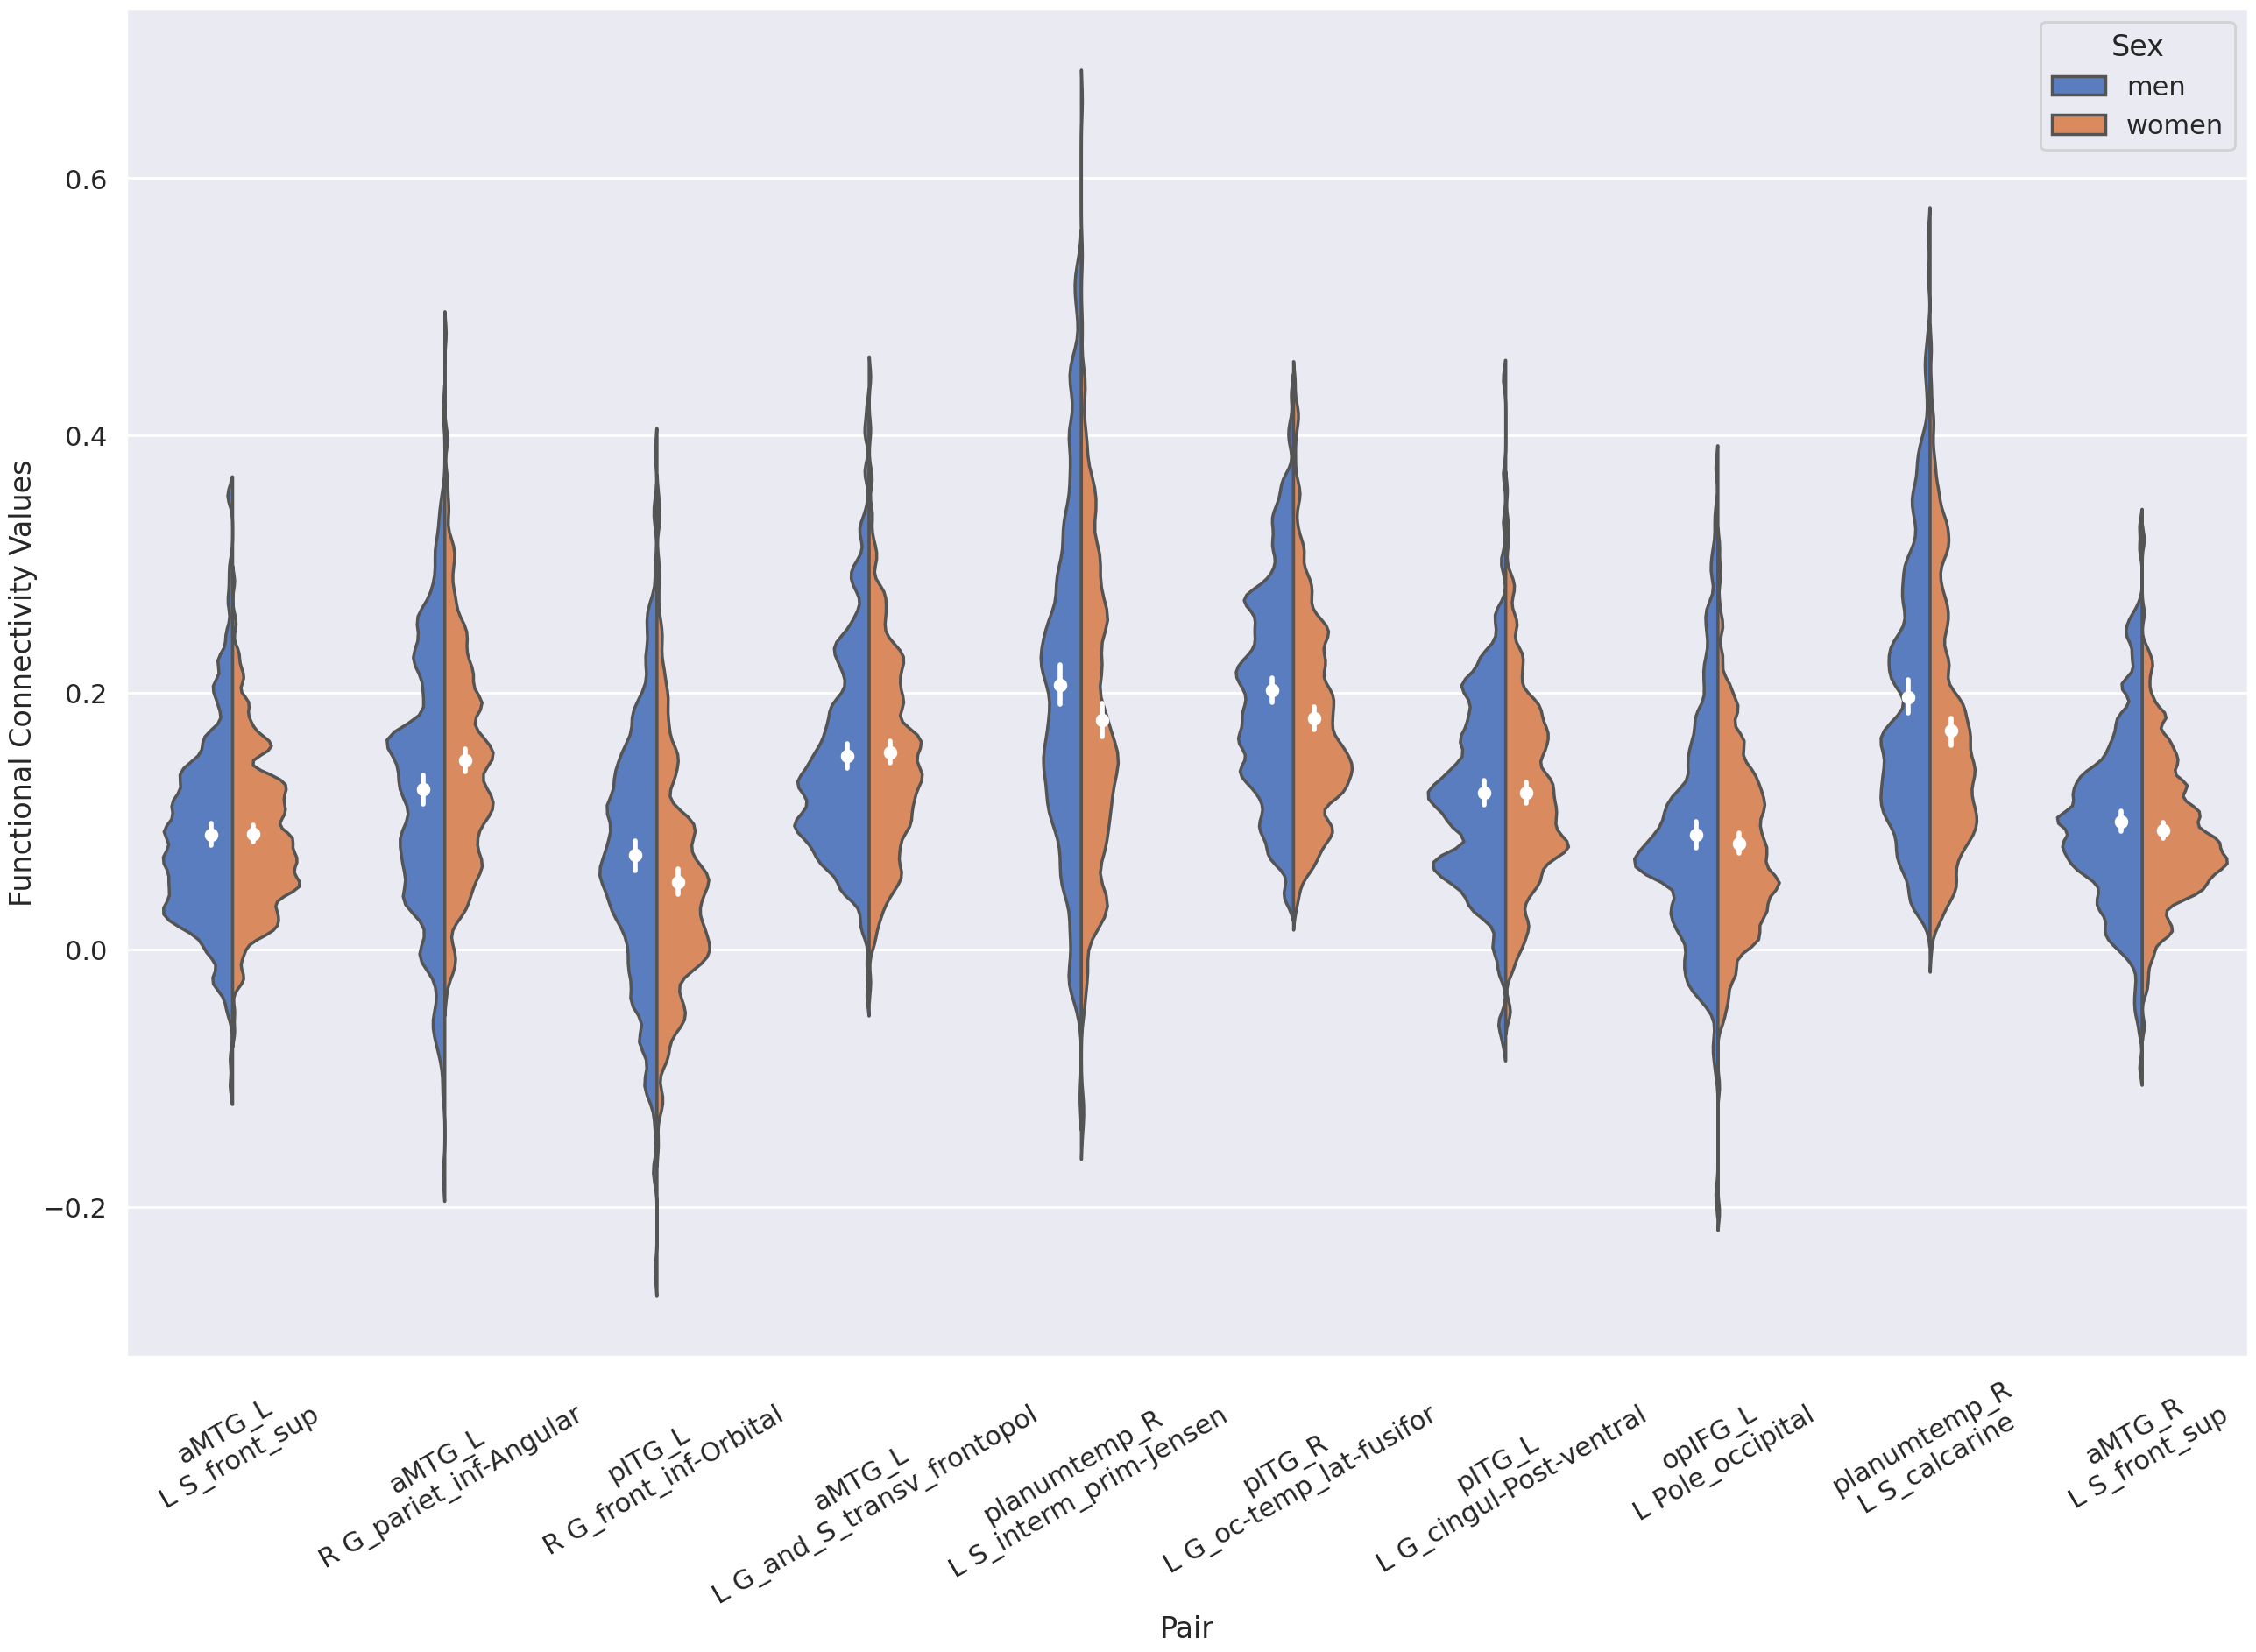

In [40]:
# list to make sure top 10 regions are in order 

top10 = ["aMTG_L with L S_front_sup",
         "aMTG_L with R G_pariet_inf-Angular",
         "pITG_L with R G_front_inf-Orbital",
         "aMTG_L with L G_and_S_transv_frontopol",
         "planumtemp_R with L S_interm_prim-Jensen", 
         "pITG_R with L G_oc-temp_lat-fusifor",
         "pITG_L with L G_cingul-Post-ventral",
         "opIFG_L with L Pole_occipital",
         "planumtemp_R with L S_calcarine", 
         "aMTG_R with L S_front_sup"]
         

df_temp = df_connectivity.loc[
    #(df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.75, order=top10, legend=False)

v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", 
                    "aMTG_L\nR G_pariet_inf-Angular",
                    "pITG_L\nR G_front_inf-Orbital", 
                    "aMTG_L\nL G_and_S_transv_frontopol",
                    "planumtemp_R\nL S_interm_prim-Jensen", 
                    "pITG_R\nL G_oc-temp_lat-fusifor",
                    "pITG_L\nL G_cingul-Post-ventral",
                    "opIFG_L\nL Pole_occipital",
                    "planumtemp_R\nL S_calcarine",
                    "aMTG_R\nL S_front_sup"], rotation=30)


fig = v_plot.get_figure()
fig.set_size_inches(31.25, 20)
fig.savefig("violin_plot.png", dpi=300)

/tmp/ipykernel_1097763/2142216917.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Sex"] = df_temp["Gender"]
/tmp/ipykernel_1097763/2142216917.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["Functional Connectivity Values"] = df_temp["value"]
/tmp/ipykernel_1097763/2142216917.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

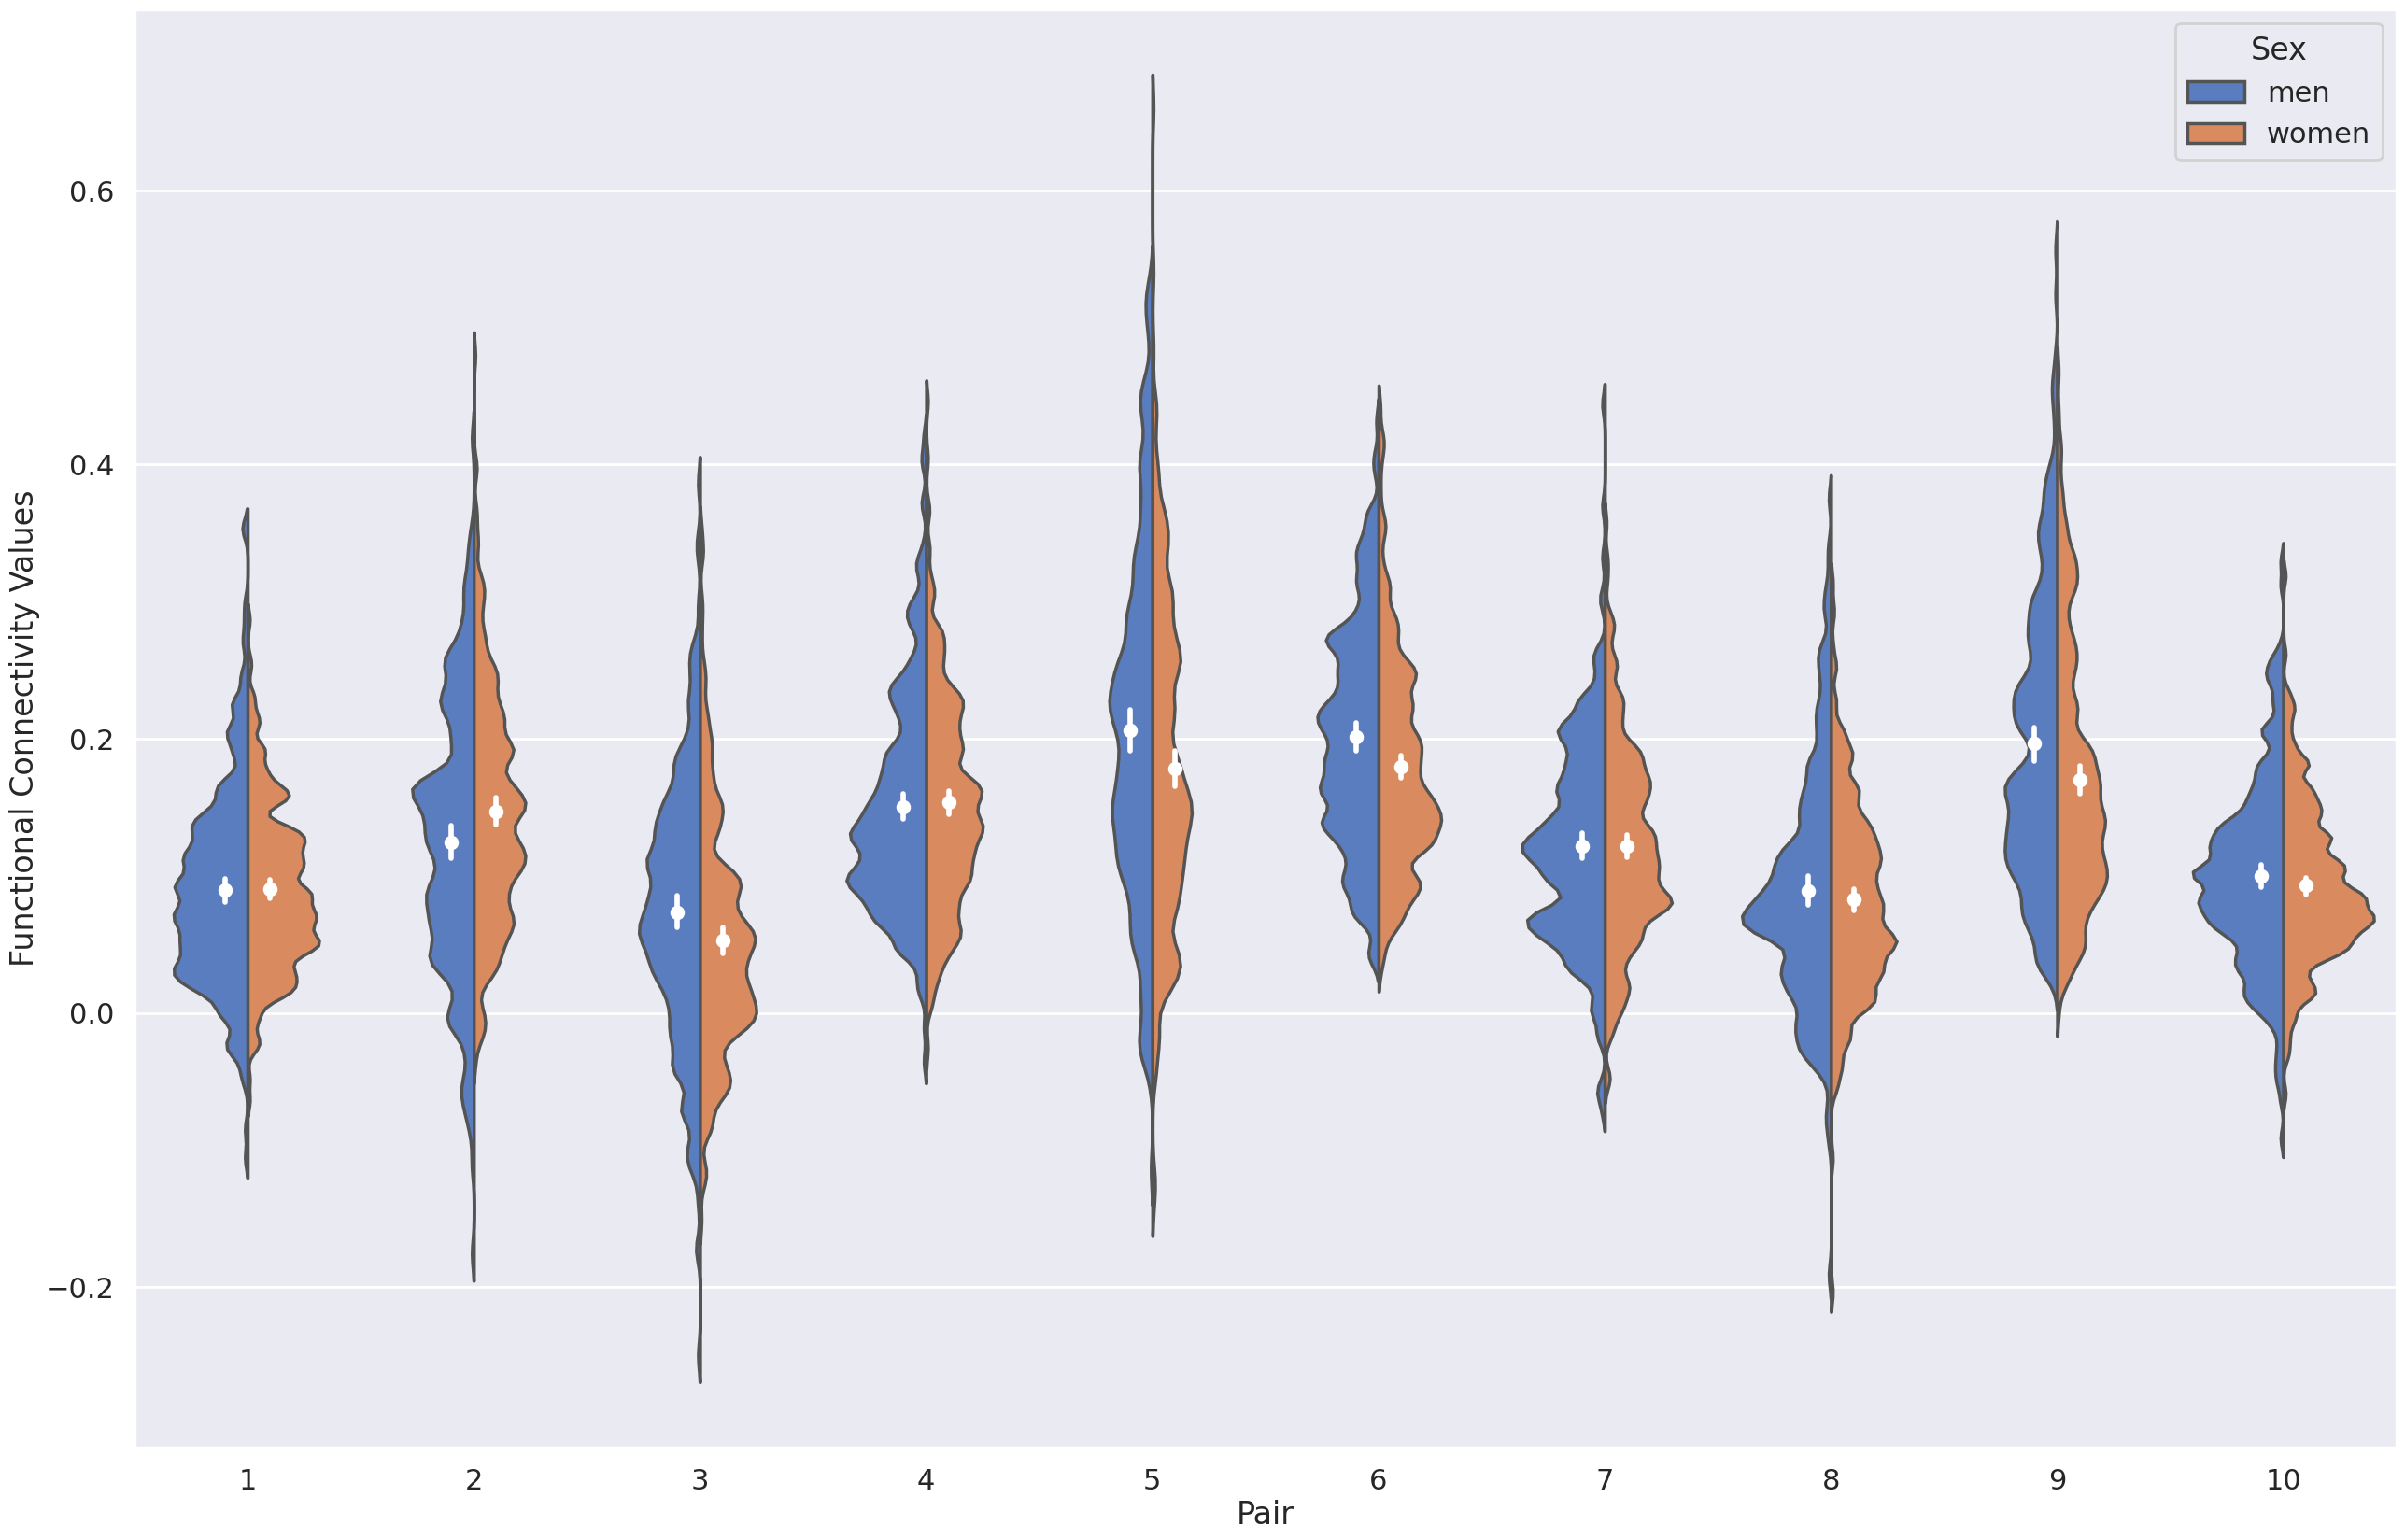

In [38]:
# list to make sure top 10 regions are in order 

top10 = ["aMTG_L with L S_front_sup",
         "aMTG_L with R G_pariet_inf-Angular",
         "pITG_L with R G_front_inf-Orbital",
         "aMTG_L with L G_and_S_transv_frontopol",
         "planumtemp_R with L S_interm_prim-Jensen", 
         "pITG_R with L G_oc-temp_lat-fusifor",
         "pITG_L with L G_cingul-Post-ventral",
         "opIFG_L with L Pole_occipital",
         "planumtemp_R with L S_calcarine", 
         "aMTG_R with L S_front_sup"]
         

df_temp = df_connectivity.loc[
    #(df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(top10))
]  
df_temp["Sex"] = df_temp["Gender"]
df_temp["Functional Connectivity Values"] = df_temp["value"]
df_temp["Pair"] = df_temp["pair"]

# plt.figure(figsize=(20, 11.25))

sns.set_theme(context="poster")

v_plot = sns.violinplot(x="Pair", y="Functional Connectivity Values", hue="Sex", data=df_temp, split= True, bw=0.10,inner = None, palette="muted", order=top10)
# v_plot.set_xticks([0,1])
# v_plot.set_xticklabels(["aMTG_L\nL S_front_sup", "2"])
# v_plot

v_plot = sns.pointplot(x="Pair", y="Functional Connectivity Values", hue="Sex",
                    data=df_temp, dodge=0.2, join=False, palette=['white'], ax=v_plot, scale=0.75, order=top10, legend=False)

v_plot.set_xticks([0,1,2,3,4,5,6,7,8,9])
v_plot.set_xticklabels(["1","2","3","4","5","6","7","8","9","10"])


fig = v_plot.get_figure()
fig.set_size_inches(31.25, 20)
fig.savefig("violin_plot_2.png", dpi=300)

In [35]:
data_results["confusion_matrix"][0]["Homme"]["Femme"]

4

## Best regions for all seeds

In [70]:
# mean confusion matrix
pdList = []
pdList.extend(data_results["confusion_matrix"])
concat_df = pd.concat(pdList)
mean_confusion = concat_df.groupby(concat_df.index)
mean_confusion.mean()

predicted class    Femme    Homme
actual class                     
Femme            55.9160   4.4486
Homme             5.0076  47.6278

      coefficient          seed                      labels
349      0.066622        aMTG_L               L S_front_sup
394      0.066252        aMTG_L      R G_pariet_inf-Angular
530      0.061393        pITG_L       R G_front_inf-Orbital
300      0.060217        aMTG_L  L G_and_S_transv_frontopol
794      0.059196  planumtemp_R      L S_interm_prim-Jensen
1056     0.058729        pITG_R     L G_oc-temp_lat-fusifor
453      0.057348        pITG_L     L G_cingul-Post-ventral
41       0.056306       opIFG_L            L Pole_occipital
783      0.055522  planumtemp_R               L S_calcarine
941      0.051270        aMTG_R               L S_front_sup
The mean accuracy : 0.916316814159292
The standard deviation of the accuracy : 0.027862591976324208
The lower boundry of the confidance interval of the accuracy : 0.8617061338856966
The upper boundry of the confidance interval of the accuracy : 0.9709274944328874


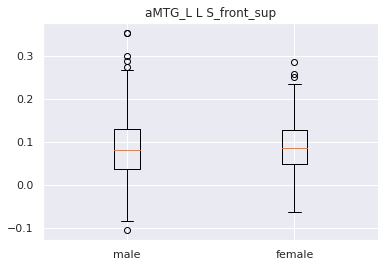

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


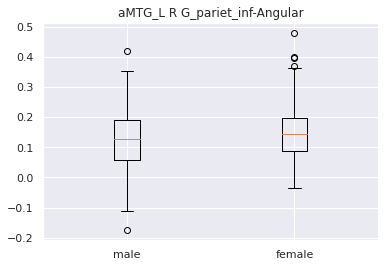

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


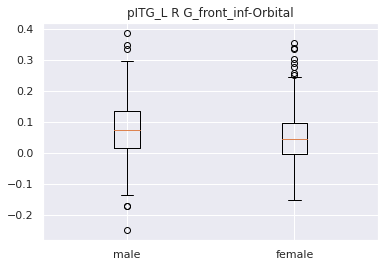

/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


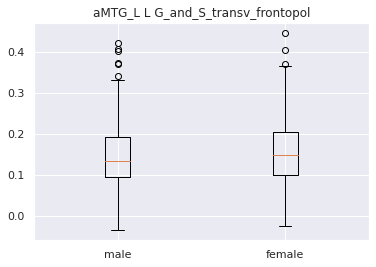

/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


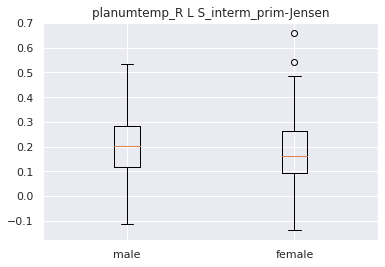

Ttest_indResult(statistic=2.6529671893777285, pvalue=0.008201963044888232)
male mean : 0.20600034
female mean : 0.17834951


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


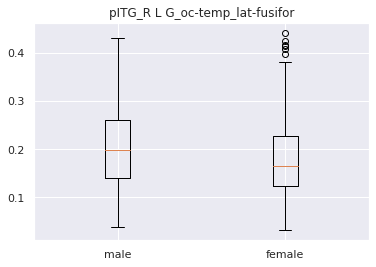

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


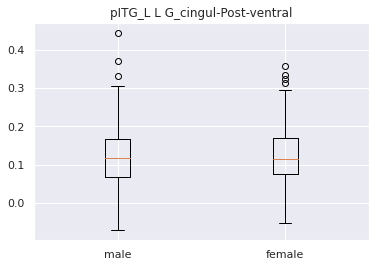

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


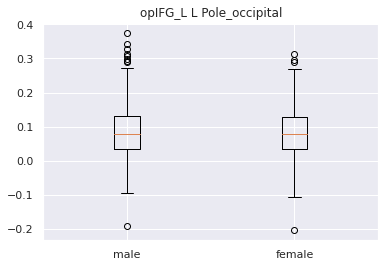

Ttest_indResult(statistic=1.0227015449858845, pvalue=0.30688434881270166)
male mean : 0.08923399
female mean : 0.08254886


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


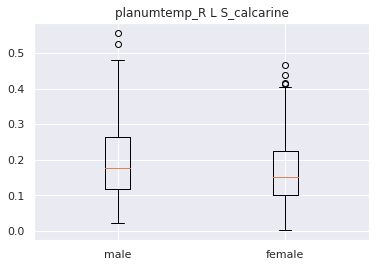

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


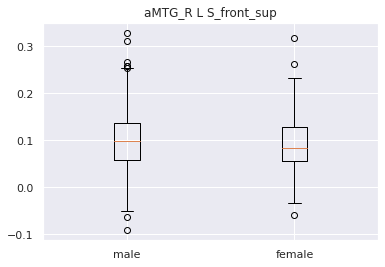

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379
                                  Region       Men     Women   P value
0                 aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1        aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2         pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
3    aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
4  planumtemp_R - L S_interm_prim-Jensen     0.206   0.17835  0.008202
5       pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
6       pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
7             opIFG_L - L Pole_occipital  0.089234  0.082549  0.306884
8           planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
9                 aMTG_R - L S_front_sup  0.099769  0.092938  0.189909


/tmp/ipykernel_3570/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [25]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for aMTG_L

     coefficient    seed                       labels
53      0.178355  aMTG_L                L S_front_sup
98      0.151544  aMTG_L       R G_pariet_inf-Angular
4       0.146723  aMTG_L   L G_and_S_transv_frontopol
78      0.120959  aMTG_L   R G_and_S_transv_frontopol
64      0.119842  aMTG_L        L S_parieto_occipital
104     0.113363  aMTG_L                   R G_rectus
55      0.109763  aMTG_L  L S_intrapariet_and_P_trans
103     0.108943  aMTG_L                R G_precuneus
135     0.106434  aMTG_L          R S_orbital_lateral
87      0.106386  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.7934628318584072
The standard deviation of the accuracy : 0.0388570983771416
The lower boundry of the confidance interval of the accuracy : 0.7173029190392096
The upper boundry of the confidance interval of the accuracy : 0.8696227446776047


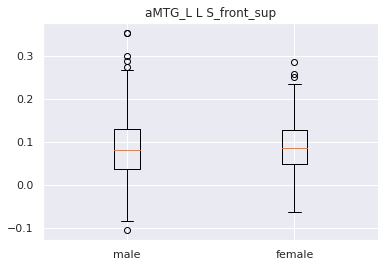

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


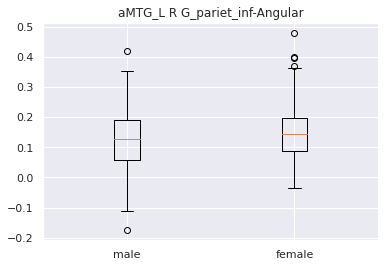

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


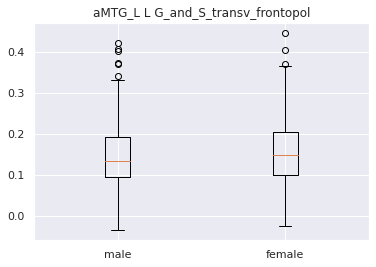

/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


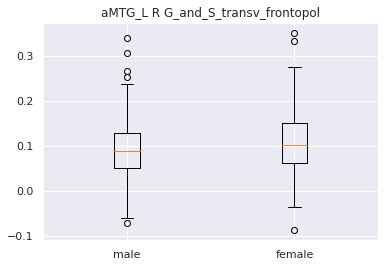

Ttest_indResult(statistic=-2.571148551614975, pvalue=0.010389553654298302)
male mean : 0.09560566
female mean : 0.10965275


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


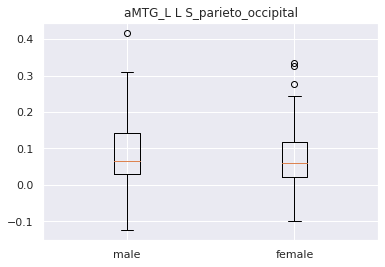

Ttest_indResult(statistic=2.436477854231027, pvalue=0.015137232912866961)
male mean : 0.08481123
female mean : 0.06949203


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


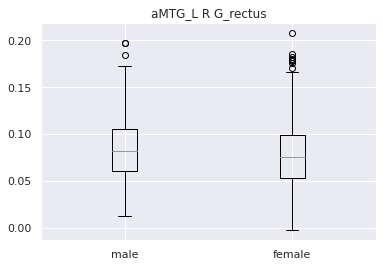

Ttest_indResult(statistic=1.7718693697468806, pvalue=0.07695230445602227)
male mean : 0.08437557
female mean : 0.0790933


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


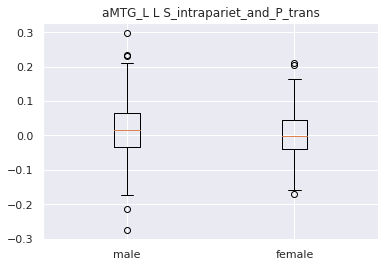

Ttest_indResult(statistic=1.5534617198947105, pvalue=0.1208698513554686)
male mean : 0.014690557
female mean : 0.005323266


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


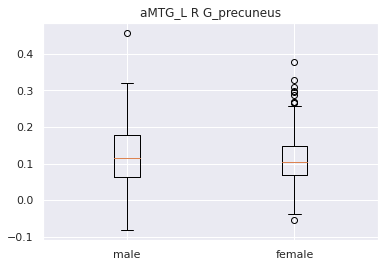

Ttest_indResult(statistic=1.328116736773145, pvalue=0.1846729623828725)
male mean : 0.11954241
female mean : 0.1113971


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


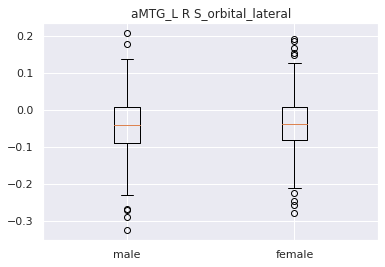

Ttest_indResult(statistic=-1.292465867685566, pvalue=0.1967213906190116)
male mean : -0.042981237
female mean : -0.034570992


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


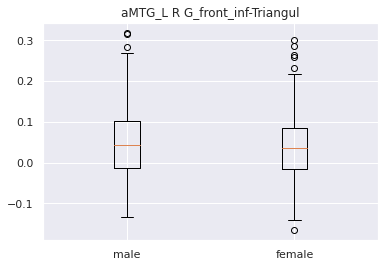

Ttest_indResult(statistic=1.1987429233926812, pvalue=0.23112780424526547)
male mean : 0.04718627
female mean : 0.03892026
                                 Region       Men     Women   P value
0                aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1       aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2   aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
3   aMTG_L - R G_and_S_transv_frontopol  0.095606  0.109653   0.01039
4        aMTG_L - L S_parieto_occipital  0.084811  0.069492  0.015137
5                   aMTG_L - R G_rectus  0.084376  0.079093  0.076952
6  aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323   0.12087
7                aMTG_L - R G_precuneus  0.119542  0.111397  0.184673
8          aMTG_L - R S_orbital_lateral -0.042981 -0.034571  0.196721
9       aMTG_L - R G_front_inf-Triangul  0.047186   0.03892  0.231128


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [48]:
rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for aMTG_R

     coefficient    seed                      labels
53      0.147067  aMTG_R               L S_front_sup
4       0.136610  aMTG_R  L G_and_S_transv_frontopol
78      0.132034  aMTG_R  R G_and_S_transv_frontopol
90      0.128443  aMTG_R   R G_Ins_lg_and_S_cent_ins
135     0.126884  aMTG_R         R S_orbital_lateral
104     0.116163  aMTG_R                  R G_rectus
66      0.114531  aMTG_R             L S_postcentral
22      0.113457  aMTG_R     L G_oc-temp_med-Parahip
98      0.110096  aMTG_R      R G_pariet_inf-Angular
99      0.108128  aMTG_R     R G_pariet_inf-Supramar
The mean accuracy : 0.7966398230088495
The standard deviation of the accuracy : 0.03879528120382583
The lower boundry of the confidance interval of the accuracy : 0.7206010718493508
The upper boundry of the confidance interval of the accuracy : 0.8726785741683482


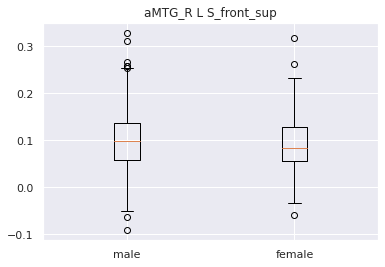

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


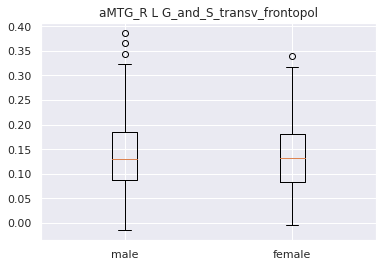

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


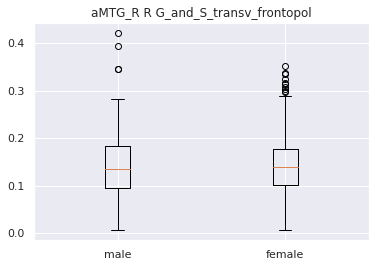

Ttest_indResult(statistic=-0.5021313679136576, pvalue=0.615769711298541)
male mean : 0.14287779
female mean : 0.14569084


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


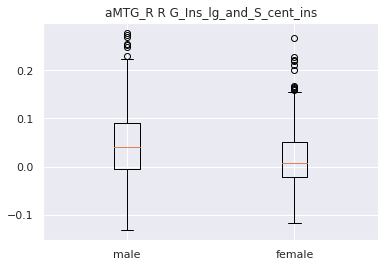

Ttest_indResult(statistic=5.221764124207272, pvalue=2.490516221055385e-07)
male mean : 0.048215896
female mean : 0.018546933


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


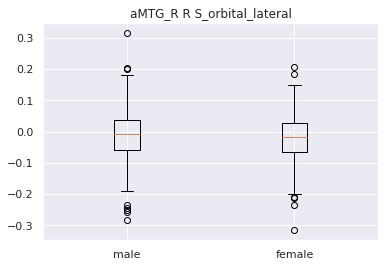

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


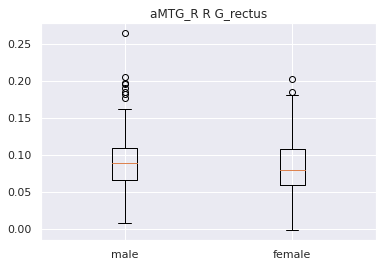

Ttest_indResult(statistic=1.9274704812509191, pvalue=0.05441935708501459)
male mean : 0.090095855
female mean : 0.08406715


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


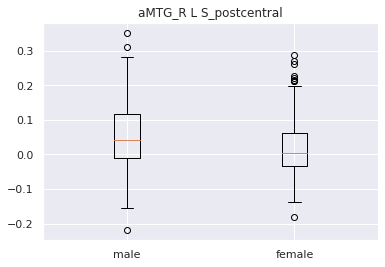

Ttest_indResult(statistic=4.322259791116856, pvalue=1.823637503842923e-05)
male mean : 0.04981075
female mean : 0.01834556


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


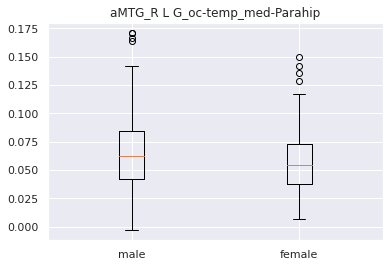

Ttest_indResult(statistic=3.283470689404765, pvalue=0.0010884267262889374)
male mean : 0.06574333
female mean : 0.057849534


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


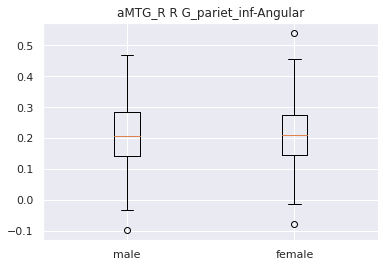

Ttest_indResult(statistic=0.3243155515075406, pvalue=0.7458185428544883)
male mean : 0.21665388
female mean : 0.21397533


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


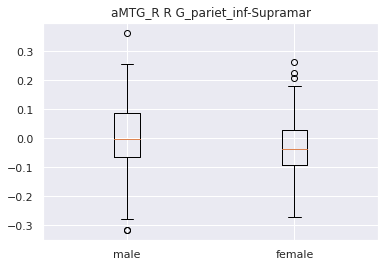

Ttest_indResult(statistic=3.8712274991600824, pvalue=0.00012086637161246554)
male mean : 0.004401155
female mean : -0.028612275
                                Region       Men     Women   P value
0               aMTG_R - L S_front_sup  0.099769  0.092938  0.189909
1  aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146   0.53795
2  aMTG_R - R G_and_S_transv_frontopol  0.142878  0.145691   0.61577
3   aMTG_R - R G_Ins_lg_and_S_cent_ins  0.048216  0.018547       0.0
4         aMTG_R - R S_orbital_lateral -0.010003 -0.016049  0.372737
5                  aMTG_R - R G_rectus  0.090096  0.084067  0.054419
6             aMTG_R - L S_postcentral  0.049811  0.018346  0.000018
7     aMTG_R - L G_oc-temp_med-Parahip  0.065743   0.05785  0.001088
8      aMTG_R - R G_pariet_inf-Angular  0.216654  0.213975  0.745819
9     aMTG_R - R G_pariet_inf-Supramar  0.004401 -0.028612  0.000121


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [50]:
rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for opIFG_L

     coefficient     seed                       labels
20      0.176945  opIFG_L      L G_oc-temp_lat-fusifor
47      0.127487  opIFG_L      L S_circular_insula_inf
72      0.121698  opIFG_L             L S_temporal_sup
40      0.121198  opIFG_L               L Lat_Fis-post
60      0.118988  opIFG_L  L S_oc-temp_med_and_Lingual
89      0.114435  opIFG_L                R G_front_sup
91      0.103522  opIFG_L            R G_insular_short
15      0.103282  opIFG_L                L G_front_sup
144     0.097858  opIFG_L              R S_subparietal
125     0.094891  opIFG_L                R S_front_inf
The mean accuracy : 0.8263690265486726
The standard deviation of the accuracy : 0.03637730928834068
The lower boundry of the confidance interval of the accuracy : 0.7550695003435248
The upper boundry of the confidance interval of the accuracy : 0.8976685527538204


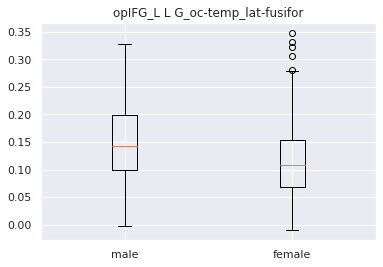

Ttest_indResult(statistic=5.8491198530470045, pvalue=8.347799493217066e-09)
male mean : 0.14884304
female mean : 0.116547726


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


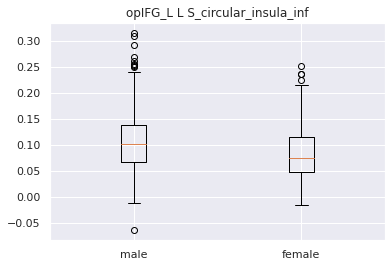

Ttest_indResult(statistic=5.852005785497293, pvalue=8.212302424670442e-09)
male mean : 0.10906584
female mean : 0.08297677


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


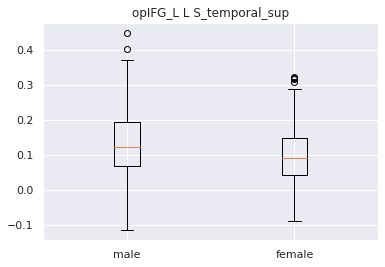

/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=5.019154197380697, pvalue=6.954734958214046e-07)
male mean : 0.13418752
female mean : 0.09735045


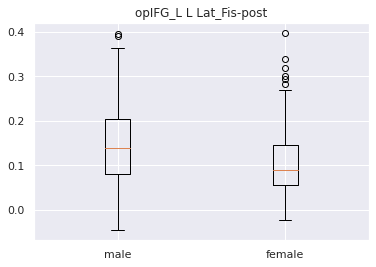

Ttest_indResult(statistic=6.364933392751482, pvalue=4.029331087681434e-10)
male mean : 0.14507884
female mean : 0.104537904


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


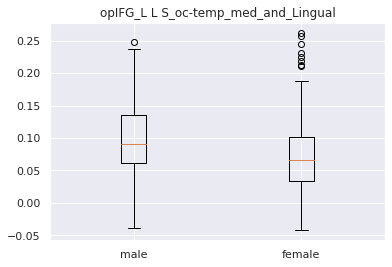

Ttest_indResult(statistic=5.76164855973489, pvalue=1.3664471966255358e-08)
male mean : 0.099059284
female mean : 0.073048


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


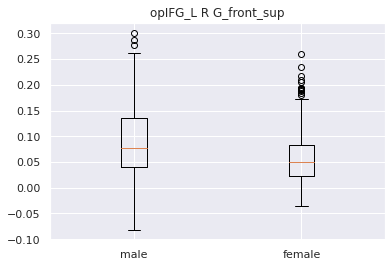

Ttest_indResult(statistic=5.707568607044662, pvalue=1.847405565322988e-08)
male mean : 0.09004138
female mean : 0.060023844


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


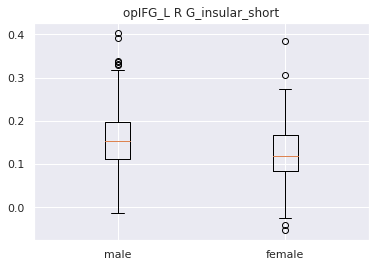

Ttest_indResult(statistic=6.392458725124564, pvalue=3.407311952931533e-10)
male mean : 0.16011919
female mean : 0.12473471


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


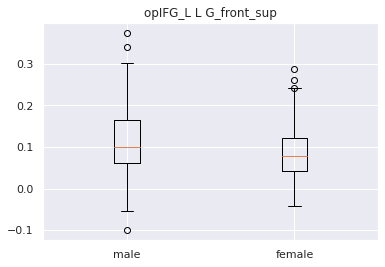

Ttest_indResult(statistic=4.949296258608313, pvalue=9.83059436081603e-07)
male mean : 0.114358306
female mean : 0.08558884


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


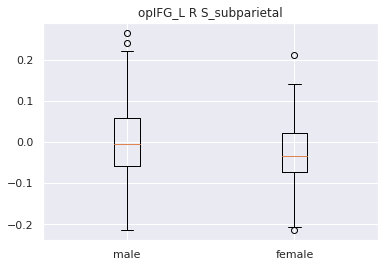

Ttest_indResult(statistic=4.51212448116301, pvalue=7.803845562268264e-06)
male mean : 0.0030093843
female mean : -0.026990896


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


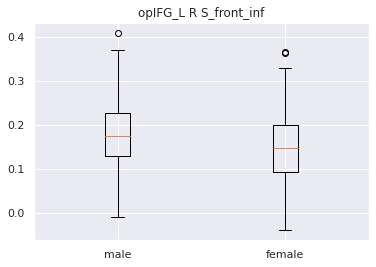

Ttest_indResult(statistic=5.638897608241495, pvalue=2.7000682578262666e-08)
male mean : 0.18022624
female mean : 0.14647487
                                  Region       Men     Women   P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.148843  0.116548       0.0
1      opIFG_L - L S_circular_insula_inf  0.109066  0.082977       0.0
2             opIFG_L - L S_temporal_sup  0.134188   0.09735  0.000001
3               opIFG_L - L Lat_Fis-post  0.145079  0.104538       0.0
4  opIFG_L - L S_oc-temp_med_and_Lingual  0.099059  0.073048       0.0
5                opIFG_L - R G_front_sup  0.090041  0.060024       0.0
6            opIFG_L - R G_insular_short  0.160119  0.124735       0.0
7                opIFG_L - L G_front_sup  0.114358  0.085589  0.000001
8              opIFG_L - R S_subparietal  0.003009 -0.026991  0.000008
9                opIFG_L - R S_front_inf  0.180226  0.146475       0.0


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [52]:
rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for opIFG_R

     coefficient     seed                       labels
121     0.164270  opIFG_R      R S_circular_insula_inf
20      0.159309  opIFG_R      L G_oc-temp_lat-fusifor
47      0.146722  opIFG_R      L S_circular_insula_inf
125     0.142245  opIFG_R                R S_front_inf
90      0.141590  opIFG_R    R G_Ins_lg_and_S_cent_ins
60      0.141188  opIFG_R  L S_oc-temp_med_and_Lingual
41      0.118799  opIFG_R             L Pole_occipital
91      0.117431  opIFG_R            R G_insular_short
80      0.114727  opIFG_R     R G_and_S_cingul-Mid-Ant
144     0.112577  opIFG_R              R S_subparietal
The mean accuracy : 0.8182610619469025
The standard deviation of the accuracy : 0.03808114602208953
The lower boundry of the confidance interval of the accuracy : 0.7436220157436071
The upper boundry of the confidance interval of the accuracy : 0.8929001081501979


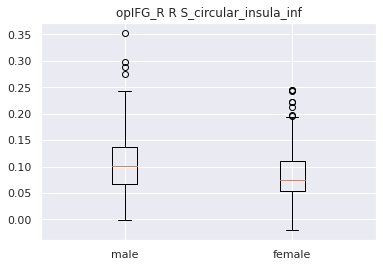

Ttest_indResult(statistic=5.226547983016146, pvalue=2.429845275450505e-07)
male mean : 0.10671159
female mean : 0.08417532


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


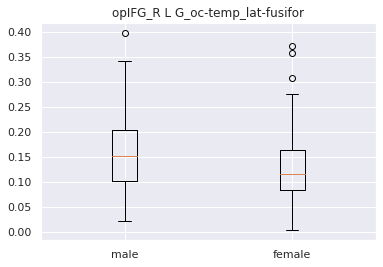

Ttest_indResult(statistic=5.732376818088248, pvalue=1.609202883985806e-08)
male mean : 0.1562101
female mean : 0.12528288


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


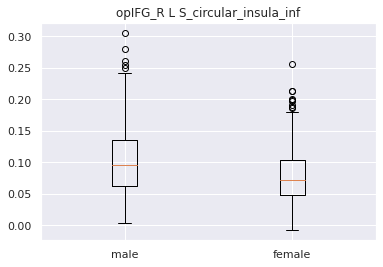

Ttest_indResult(statistic=5.209214471386057, pvalue=2.656732376950302e-07)
male mean : 0.10079068
female mean : 0.079217285


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


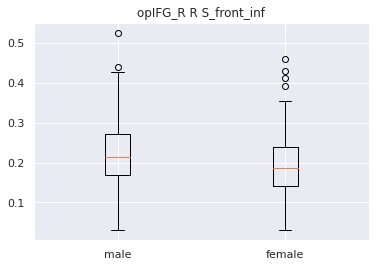

Ttest_indResult(statistic=5.115644829965803, pvalue=4.282989746232668e-07)
male mean : 0.2219755
female mean : 0.1895739


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


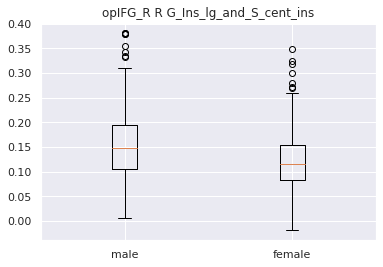

Ttest_indResult(statistic=5.739625655933474, pvalue=1.545440086293778e-08)
male mean : 0.15487437
female mean : 0.12380144


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


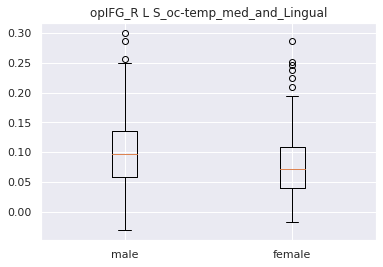

Ttest_indResult(statistic=4.827321505738625, pvalue=1.7812051723580022e-06)
male mean : 0.10082634
female mean : 0.07872187


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


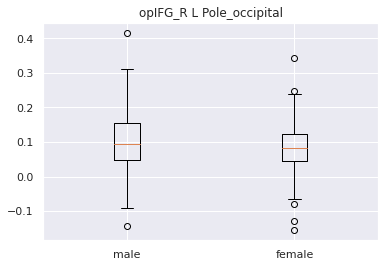

Ttest_indResult(statistic=2.8938857514023053, pvalue=0.0039511454822068635)
male mean : 0.104489796
female mean : 0.086915694


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


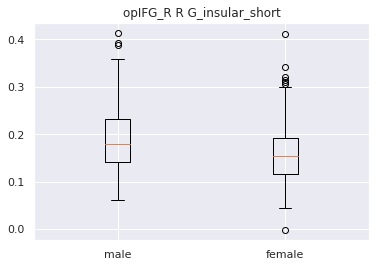

Ttest_indResult(statistic=6.055881429843483, pvalue=2.5410117264590037e-09)
male mean : 0.18950616
female mean : 0.15782672


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


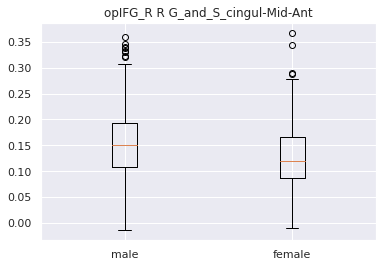

Ttest_indResult(statistic=5.1899086135822605, pvalue=2.933595035412797e-07)
male mean : 0.15612759
female mean : 0.12868549


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


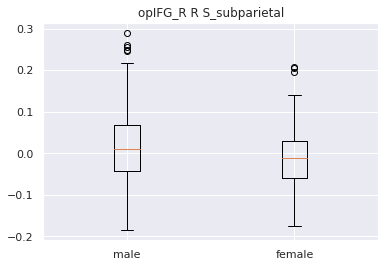

Ttest_indResult(statistic=4.565861009572576, pvalue=6.1028631539739194e-06)
male mean : 0.016530583
female mean : -0.012515795
                                  Region       Men     Women   P value
0      opIFG_R - R S_circular_insula_inf  0.106712  0.084175       0.0
1      opIFG_R - L G_oc-temp_lat-fusifor   0.15621  0.125283       0.0
2      opIFG_R - L S_circular_insula_inf  0.100791  0.079217       0.0
3                opIFG_R - R S_front_inf  0.221976  0.189574       0.0
4    opIFG_R - R G_Ins_lg_and_S_cent_ins  0.154874  0.123801       0.0
5  opIFG_R - L S_oc-temp_med_and_Lingual  0.100826  0.078722  0.000002
6             opIFG_R - L Pole_occipital   0.10449  0.086916  0.003951
7            opIFG_R - R G_insular_short  0.189506  0.157827       0.0
8     opIFG_R - R G_and_S_cingul-Mid-Ant  0.156128  0.128685       0.0
9              opIFG_R - R S_subparietal  0.016531 -0.012516  0.000006


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [54]:
rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for pITG_L

     coefficient    seed                       labels
9       0.195014  pITG_L      L G_cingul-Post-ventral
26      0.170764  pITG_L             L G_parietal_sup
20      0.166594  pITG_L      L G_oc-temp_lat-fusifor
86      0.151776  pITG_L        R G_front_inf-Orbital
55      0.143774  pITG_L  L S_intrapariet_and_P_trans
125     0.131312  pITG_L                R S_front_inf
83      0.128657  pITG_L      R G_cingul-Post-ventral
4       0.126899  pITG_L   L G_and_S_transv_frontopol
115     0.122120  pITG_L             R Pole_occipital
66      0.120163  pITG_L              L S_postcentral
The mean accuracy : 0.8041539823008849
The standard deviation of the accuracy : 0.038765247723237035
The lower boundry of the confidance interval of the accuracy : 0.7281740967633403
The upper boundry of the confidance interval of the accuracy : 0.8801338678384294


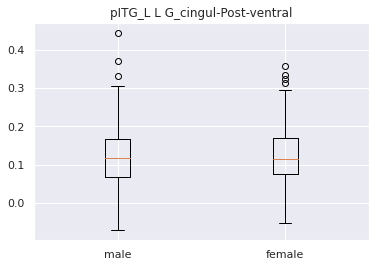

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


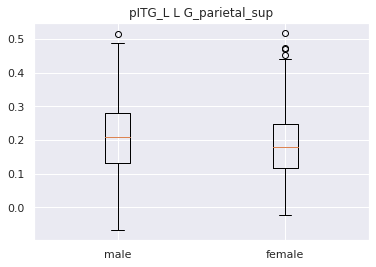

Ttest_indResult(statistic=2.776333935754648, pvalue=0.005678904619509242)
male mean : 0.21009725
female mean : 0.18630977


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


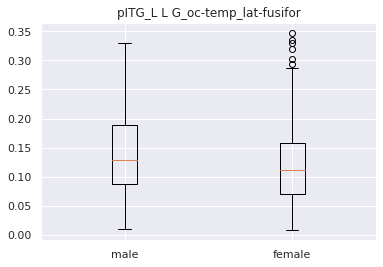

Ttest_indResult(statistic=3.156077082866602, pvalue=0.0016837809817830673)
male mean : 0.13884458
female mean : 0.1213442


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


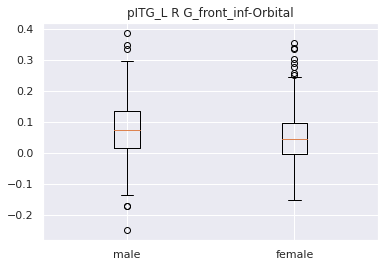

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


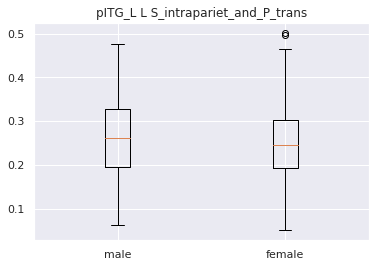

Ttest_indResult(statistic=2.210150284070341, pvalue=0.027492662382419545)
male mean : 0.2640814
female mean : 0.24852245


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


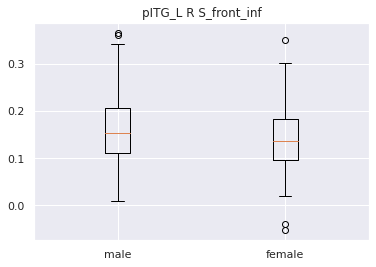

Ttest_indResult(statistic=3.4759879317703635, pvalue=0.0005478613658807853)
male mean : 0.16004132
female mean : 0.14065996


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


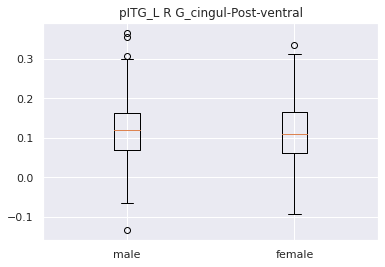

Ttest_indResult(statistic=0.09601695482038536, pvalue=0.9235409730092512)
male mean : 0.11851825
female mean : 0.11792118


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


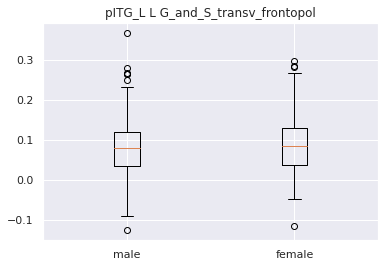

Ttest_indResult(statistic=-0.7998487955908873, pvalue=0.42413278500505813)
male mean : 0.083293684
female mean : 0.08794802


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


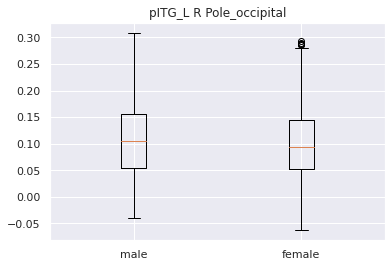

Ttest_indResult(statistic=1.39165171012916, pvalue=0.1645726291539082)
male mean : 0.11096361
female mean : 0.10281154


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


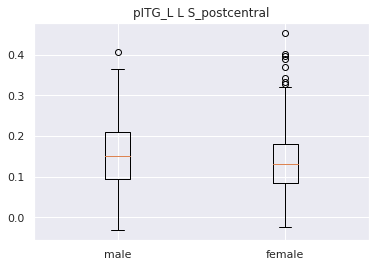

Ttest_indResult(statistic=2.5890681056057545, pvalue=0.009870223882467003)
male mean : 0.15819883
female mean : 0.14057475
                                 Region       Men     Women   P value
0      pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
1             pITG_L - L G_parietal_sup  0.210097   0.18631  0.005679
2      pITG_L - L G_oc-temp_lat-fusifor  0.138845  0.121344  0.001684
3        pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4  pITG_L - L S_intrapariet_and_P_trans  0.264081  0.248522  0.027493
5                pITG_L - R S_front_inf  0.160041   0.14066  0.000548
6      pITG_L - R G_cingul-Post-ventral  0.118518  0.117921  0.923541
7   pITG_L - L G_and_S_transv_frontopol  0.083294  0.087948  0.424133
8             pITG_L - R Pole_occipital  0.110964  0.102812  0.164573
9              pITG_L - L S_postcentral  0.158199  0.140575   0.00987


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [56]:
rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for pITG_R

     coefficient    seed                     labels
20      0.211686  pITG_R    L G_oc-temp_lat-fusifor
125     0.169432  pITG_R              R S_front_inf
72      0.152691  pITG_R           L S_temporal_sup
83      0.143931  pITG_R    R G_cingul-Post-ventral
84      0.123300  pITG_R                 R G_cuneus
90      0.111515  pITG_R  R G_Ins_lg_and_S_cent_ins
66      0.110934  pITG_R            L S_postcentral
47      0.106226  pITG_R    L S_circular_insula_inf
80      0.102170  pITG_R   R G_and_S_cingul-Mid-Ant
144     0.098461  pITG_R            R S_subparietal
The mean accuracy : 0.803787610619469
The standard deviation of the accuracy : 0.03911586112149067
The lower boundry of the confidance interval of the accuracy : 0.7271205228213473
The upper boundry of the confidance interval of the accuracy : 0.8804546984175907


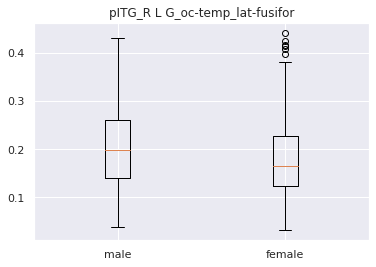

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


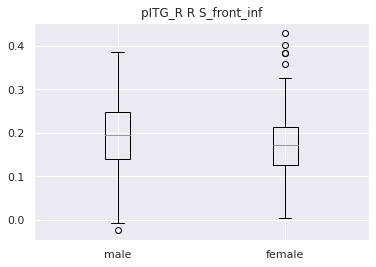

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


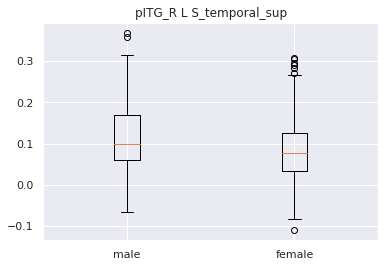

/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=5.074089384931722, pvalue=5.282429620160145e-07)
male mean : 0.11588306
female mean : 0.082715824


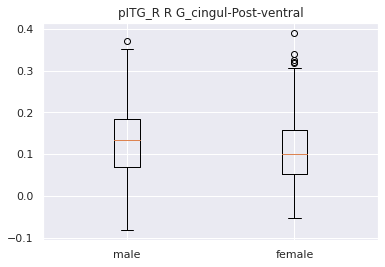

Ttest_indResult(statistic=2.7984808337835725, pvalue=0.0053086933505674845)
male mean : 0.1303599
female mean : 0.110936716


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


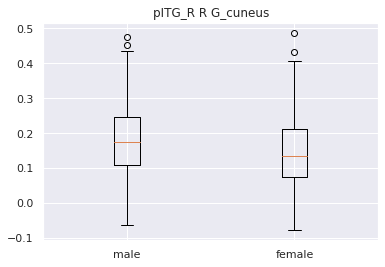

Ttest_indResult(statistic=3.905515094980048, pvalue=0.00010533315735719154)
male mean : 0.18062297
female mean : 0.14835264


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


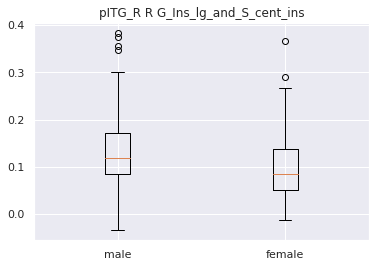

Ttest_indResult(statistic=5.819424388125569, pvalue=9.874878092431944e-09)
male mean : 0.12975526
female mean : 0.09711951


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


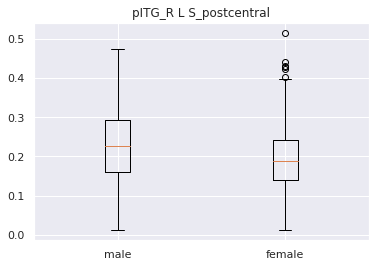

Ttest_indResult(statistic=4.500613935739143, pvalue=8.223189970303467e-06)
male mean : 0.22811967
female mean : 0.19511805


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


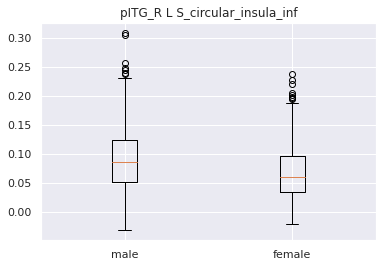

Ttest_indResult(statistic=5.3129048307989155, pvalue=1.5516951922225732e-07)
male mean : 0.093431704
female mean : 0.07025469


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


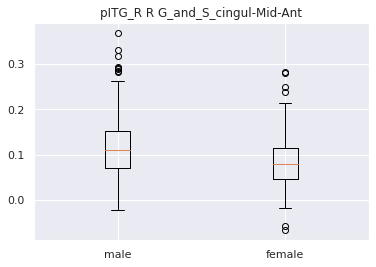

Ttest_indResult(statistic=6.329006454311802, pvalue=5.010627605450198e-10)
male mean : 0.116088144
female mean : 0.08355036


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


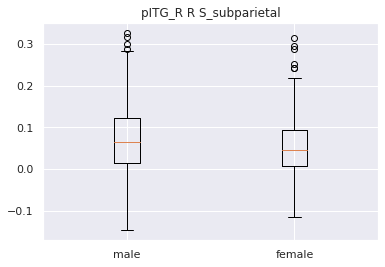

Ttest_indResult(statistic=3.0028167290028893, pvalue=0.002792640236251615)
male mean : 0.07293796
female mean : 0.053484038
                               Region       Men     Women   P value
0    pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
1              pITG_R - R S_front_inf  0.195457  0.174584  0.000361
2           pITG_R - L S_temporal_sup  0.115883  0.082716  0.000001
3    pITG_R - R G_cingul-Post-ventral   0.13036  0.110937  0.005309
4                 pITG_R - R G_cuneus  0.180623  0.148353  0.000105
5  pITG_R - R G_Ins_lg_and_S_cent_ins  0.129755   0.09712       0.0
6            pITG_R - L S_postcentral   0.22812  0.195118  0.000008
7    pITG_R - L S_circular_insula_inf  0.093432  0.070255       0.0
8   pITG_R - R G_and_S_cingul-Mid-Ant  0.116088   0.08355       0.0
9            pITG_R - R S_subparietal  0.072938  0.053484  0.002793


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [58]:
rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for planumtemp_L

     coefficient          seed                       labels
20      0.189321  planumtemp_L      L G_oc-temp_lat-fusifor
60      0.173715  planumtemp_L  L S_oc-temp_med_and_Lingual
94      0.153142  planumtemp_L      R G_oc-temp_lat-fusifor
108     0.145997  planumtemp_L      R G_temp_sup-Plan_polar
15      0.123992  planumtemp_L                L G_front_sup
43      0.119040  planumtemp_L                L S_calcarine
66      0.118139  planumtemp_L              L S_postcentral
80      0.103801  planumtemp_L     R G_and_S_cingul-Mid-Ant
90      0.103567  planumtemp_L    R G_Ins_lg_and_S_cent_ins
47      0.102969  planumtemp_L      L S_circular_insula_inf
The mean accuracy : 0.7950212389380531
The standard deviation of the accuracy : 0.03926348444477098
The lower boundry of the confidance interval of the accuracy : 0.718064809426302
The upper boundry of the confidance interval of the accuracy : 0.8719776684498042


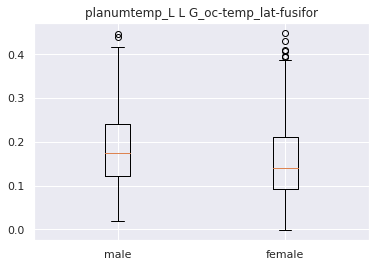

Ttest_indResult(statistic=3.884599647610934, pvalue=0.00011456706619806536)
male mean : 0.18645073
female mean : 0.1582872


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


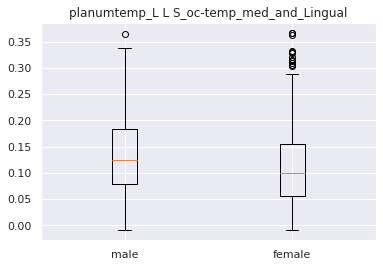

Ttest_indResult(statistic=3.020211908506582, pvalue=0.002639537757200332)
male mean : 0.13396002
female mean : 0.11491338


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


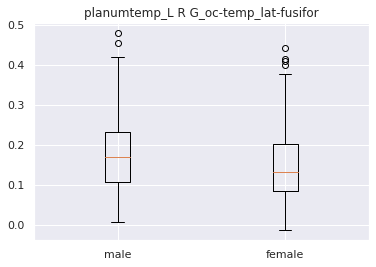

/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=3.844351881138195, pvalue=0.000134530254843104)
male mean : 0.17783996
female mean : 0.14997594


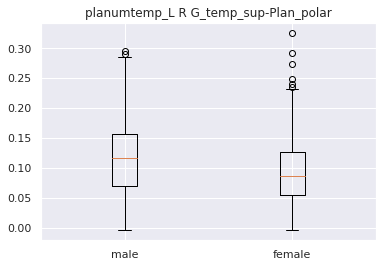

Ttest_indResult(statistic=4.709075761335283, pvalue=3.131282089799687e-06)
male mean : 0.120655425
female mean : 0.09793018


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


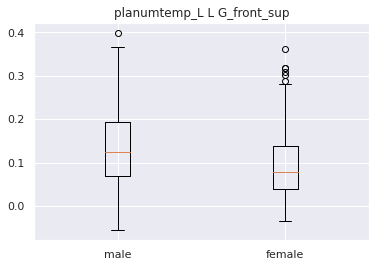

Ttest_indResult(statistic=6.277384960162231, pvalue=6.841155938453079e-10)
male mean : 0.13300735
female mean : 0.09150557


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


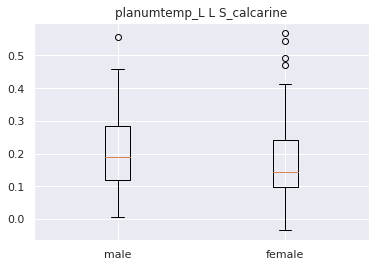

Ttest_indResult(statistic=3.6505599712750856, pvalue=0.0002858230530319466)
male mean : 0.20659167
female mean : 0.17391653


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


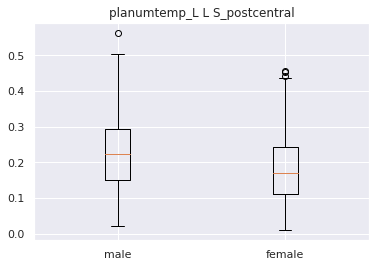

Ttest_indResult(statistic=5.2088191369728305, pvalue=2.6621392371627445e-07)
male mean : 0.22551109
female mean : 0.18211527


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


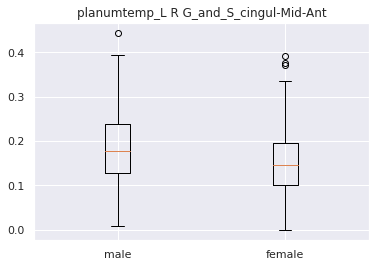

Ttest_indResult(statistic=4.94145850208659, pvalue=1.0217181392073479e-06)
male mean : 0.18532187
female mean : 0.15326016


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


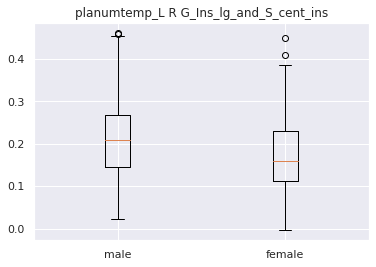

Ttest_indResult(statistic=4.78270058126534, pvalue=2.206867824814024e-06)
male mean : 0.21097915
female mean : 0.17569473


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


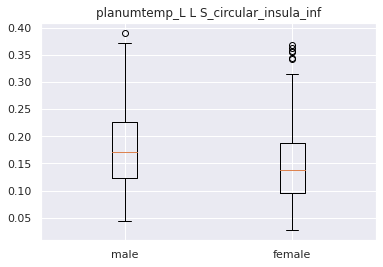

Ttest_indResult(statistic=4.687780341716563, pvalue=3.4617640004702806e-06)
male mean : 0.17687188
female mean : 0.14962009
                                       Region       Men     Women   P value
0      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287  0.000115
1  planumtemp_L - L S_oc-temp_med_and_Lingual   0.13396  0.114913   0.00264
2      planumtemp_L - R G_oc-temp_lat-fusifor   0.17784  0.149976  0.000135
3      planumtemp_L - R G_temp_sup-Plan_polar  0.120655   0.09793  0.000003
4                planumtemp_L - L G_front_sup  0.133007  0.091506       0.0
5                planumtemp_L - L S_calcarine  0.206592  0.173917  0.000286
6              planumtemp_L - L S_postcentral  0.225511  0.182115       0.0
7     planumtemp_L - R G_and_S_cingul-Mid-Ant  0.185322   0.15326  0.000001
8    planumtemp_L - R G_Ins_lg_and_S_cent_ins  0.210979  0.175695  0.000002
9      planumtemp_L - L S_circular_insula_inf  0.176872   0.14962  0.000003


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [61]:
rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for planumtemp_R

     coefficient          seed                       labels
72      0.194317  planumtemp_R             L S_temporal_sup
47      0.168153  planumtemp_R      L S_circular_insula_inf
60      0.163241  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.163170  planumtemp_R                L S_calcarine
108     0.160715  planumtemp_R      R G_temp_sup-Plan_polar
121     0.158024  planumtemp_R      R S_circular_insula_inf
20      0.151622  planumtemp_R      L G_oc-temp_lat-fusifor
78      0.118345  planumtemp_R   R G_and_S_transv_frontopol
15      0.114704  planumtemp_R                L G_front_sup
80      0.114545  planumtemp_R     R G_and_S_cingul-Mid-Ant
The mean accuracy : 0.7848601769911504
The standard deviation of the accuracy : 0.039920238590652524
The lower boundry of the confidance interval of the accuracy : 0.7066165093534714
The upper boundry of the confidance interval of the accuracy : 0.8631038446288294


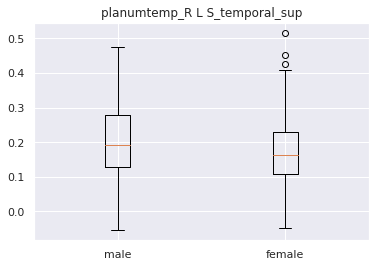

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


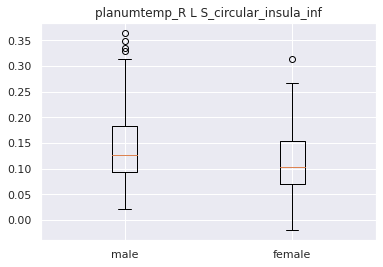

Ttest_indResult(statistic=5.007456260267843, pvalue=7.371794588395764e-07)
male mean : 0.14035343
female mean : 0.11432696


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


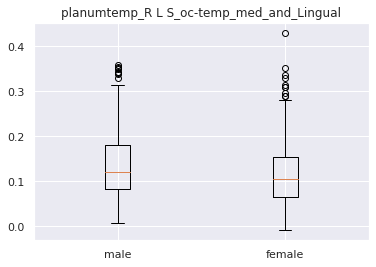

Ttest_indResult(statistic=3.0624233052403027, pvalue=0.00229945814708059)
male mean : 0.13526098
female mean : 0.116651125


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


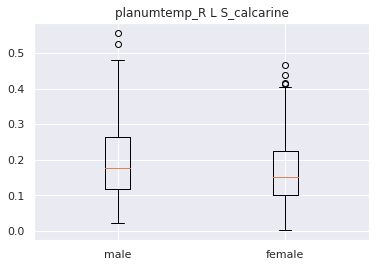

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


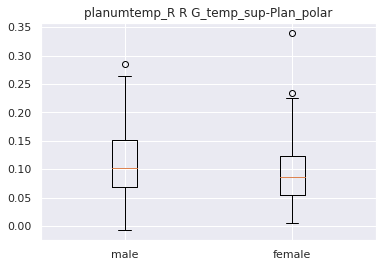

Ttest_indResult(statistic=3.672343154381283, pvalue=0.0002630403504360859)
male mean : 0.111256644
female mean : 0.09470312


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


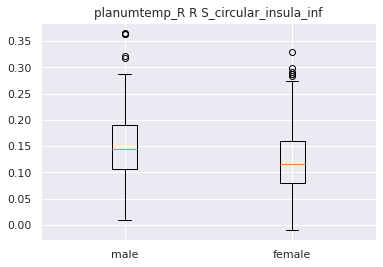

Ttest_indResult(statistic=5.1698335247619145, pvalue=3.2510555654335486e-07)
male mean : 0.15255034
female mean : 0.12557979


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


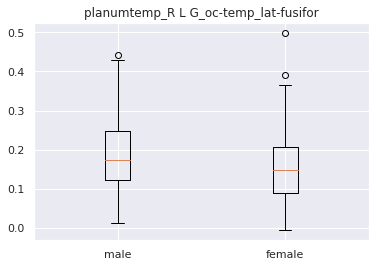

Ttest_indResult(statistic=4.196349599946236, pvalue=3.147371906718927e-05)
male mean : 0.18705179
female mean : 0.15669796


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


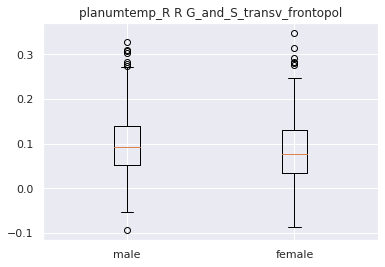

Ttest_indResult(statistic=2.4450835297243194, pvalue=0.014784556396720787)
male mean : 0.09999801
female mean : 0.084834725


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


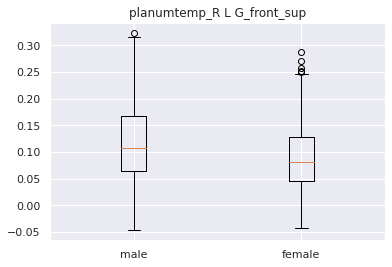

Ttest_indResult(statistic=4.713042385999811, pvalue=3.07317312687487e-06)
male mean : 0.11826675
female mean : 0.09100003


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


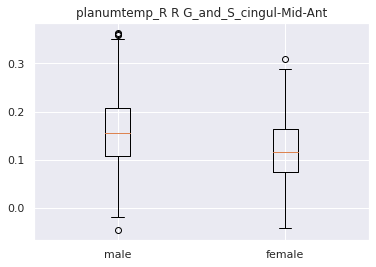

Ttest_indResult(statistic=6.041387569168192, pvalue=2.765055674671749e-09)
male mean : 0.15823741
female mean : 0.12321305
                                       Region       Men     Women   P value
0             planumtemp_R - L S_temporal_sup  0.203941  0.174168  0.000332
1      planumtemp_R - L S_circular_insula_inf  0.140353  0.114327  0.000001
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651  0.002299
3                planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
4      planumtemp_R - R G_temp_sup-Plan_polar  0.111257  0.094703  0.000263
5      planumtemp_R - R S_circular_insula_inf   0.15255   0.12558       0.0
6      planumtemp_R - L G_oc-temp_lat-fusifor  0.187052  0.156698  0.000031
7   planumtemp_R - R G_and_S_transv_frontopol  0.099998  0.084835  0.014785
8                planumtemp_R - L G_front_sup  0.118267     0.091  0.000003
9     planumtemp_R - R G_and_S_cingul-Mid-Ant  0.158237  0.123213       0.0


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [63]:
rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for all left seed

     coefficient          seed                       labels
349     0.102400        aMTG_L                L S_front_sup
300     0.091829        aMTG_L   L G_and_S_transv_frontopol
394     0.090066        aMTG_L       R G_pariet_inf-Angular
530     0.088605        pITG_L        R G_front_inf-Orbital
470     0.083745        pITG_L             L G_parietal_sup
453     0.079787        pITG_L      L G_cingul-Post-ventral
208     0.077748  planumtemp_L  L S_oc-temp_med_and_Lingual
569     0.074870        pITG_L                R S_front_inf
351     0.073992        aMTG_L  L S_intrapariet_and_P_trans
168     0.070939  planumtemp_L      L G_oc-temp_lat-fusifor
The mean accuracy : 0.9104362831858407
The standard deviation of the accuracy : 0.028102231489263784
The lower boundry of the confidance interval of the accuracy : 0.8553559094668837
The upper boundry of the confidance interval of the accuracy : 0.9655166569047977


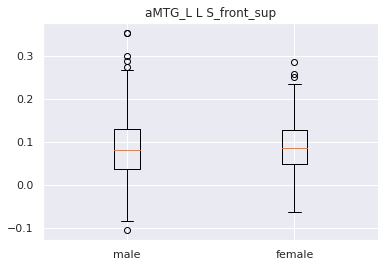

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


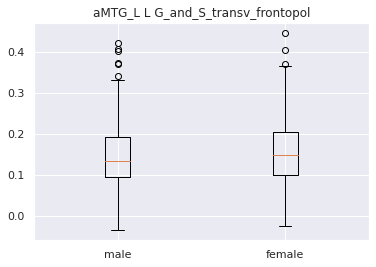

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


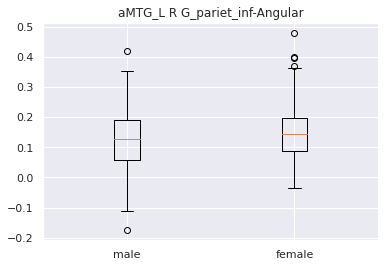

/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


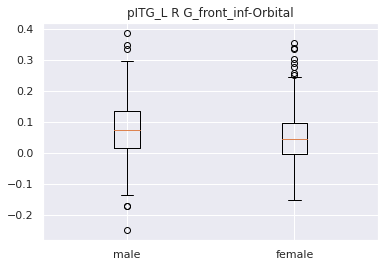

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


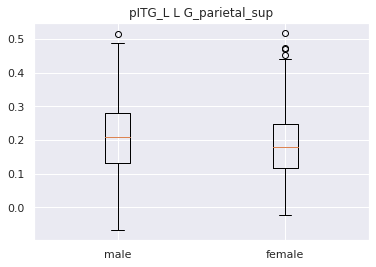

Ttest_indResult(statistic=2.776333935754648, pvalue=0.005678904619509242)
male mean : 0.21009725
female mean : 0.18630977


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


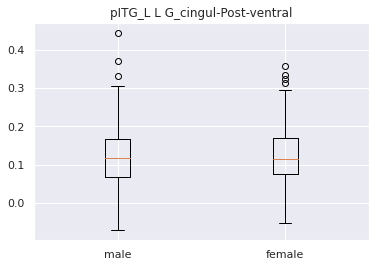

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


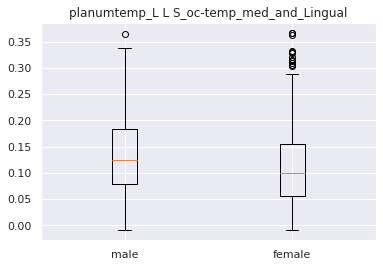

Ttest_indResult(statistic=3.020211908506582, pvalue=0.002639537757200332)
male mean : 0.13396002
female mean : 0.11491338


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


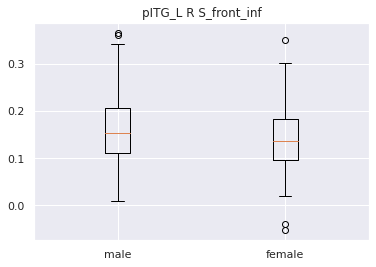

Ttest_indResult(statistic=3.4759879317703635, pvalue=0.0005478613658807853)
male mean : 0.16004132
female mean : 0.14065996


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


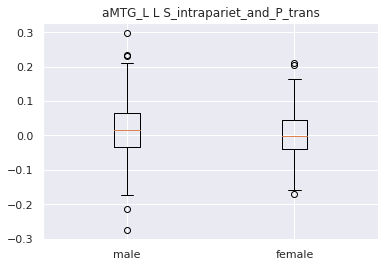

Ttest_indResult(statistic=1.5534617198947105, pvalue=0.1208698513554686)
male mean : 0.014690557
female mean : 0.005323266


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


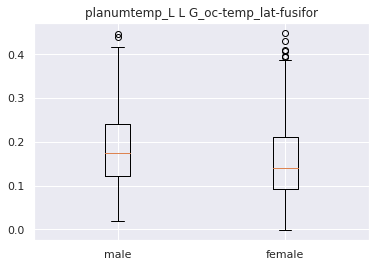

Ttest_indResult(statistic=3.884599647610934, pvalue=0.00011456706619806536)
male mean : 0.18645073
female mean : 0.1582872
                                       Region       Men     Women   P value
0                      aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1         aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
2             aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
3              pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4                   pITG_L - L G_parietal_sup  0.210097   0.18631  0.005679
5            pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
6  planumtemp_L - L S_oc-temp_med_and_Lingual   0.13396  0.114913   0.00264
7                      pITG_L - R S_front_inf  0.160041   0.14066  0.000548
8        aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323   0.12087
9      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287  0.000115


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [65]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

## Best region for all right seed

     coefficient          seed                       labels
464     0.102624        pITG_R      L G_oc-temp_lat-fusifor
349     0.101303        aMTG_R                L S_front_sup
191     0.091369  planumtemp_R                L S_calcarine
569     0.088145        pITG_R                R S_front_inf
379     0.083668        aMTG_R      R G_cingul-Post-ventral
144     0.082295       opIFG_R              R S_subparietal
300     0.079917        aMTG_R   L G_and_S_transv_frontopol
431     0.079634        aMTG_R          R S_orbital_lateral
208     0.079235  planumtemp_R  L S_oc-temp_med_and_Lingual
220     0.078191  planumtemp_R             L S_temporal_sup
The mean accuracy : 0.9012778761061947
The standard deviation of the accuracy : 0.029758982557172946
The lower boundry of the confidance interval of the accuracy : 0.8429502702941357
The upper boundry of the confidance interval of the accuracy : 0.9596054819182537


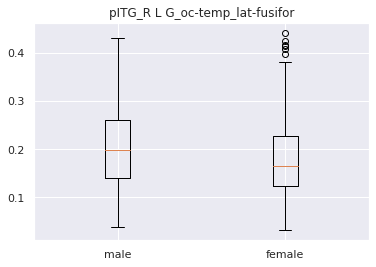

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


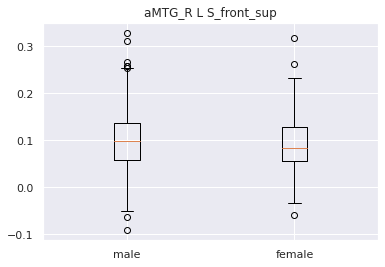

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


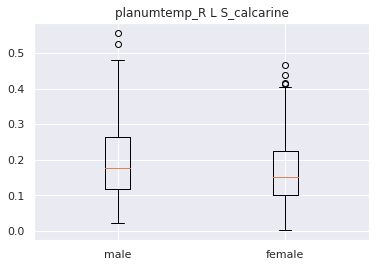

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


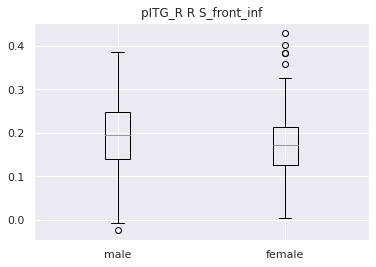

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


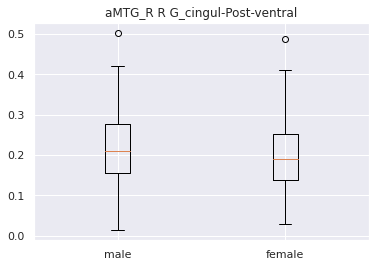

Ttest_indResult(statistic=2.9173803459664653, pvalue=0.0036694581263624366)
male mean : 0.2160543
female mean : 0.1958651


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


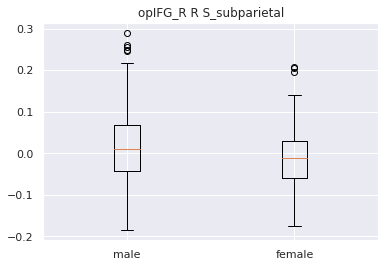

Ttest_indResult(statistic=4.565861009572576, pvalue=6.1028631539739194e-06)
male mean : 0.016530583
female mean : -0.012515795


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


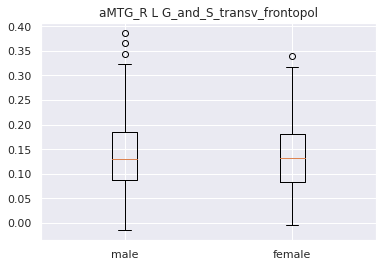

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


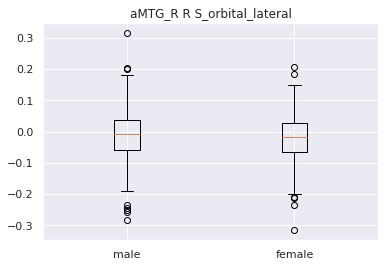

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


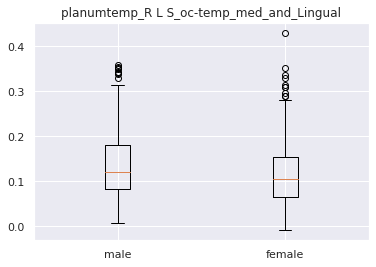

Ttest_indResult(statistic=3.0624233052403027, pvalue=0.00229945814708059)
male mean : 0.13526098
female mean : 0.116651125


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


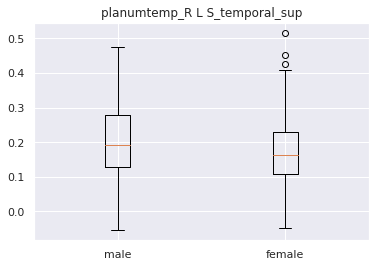

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676
                                       Region       Men     Women   P value
0            pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
1                      aMTG_R - L S_front_sup  0.099769  0.092938  0.189909
2                planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
3                      pITG_R - R S_front_inf  0.195457  0.174584  0.000361
4            aMTG_R - R G_cingul-Post-ventral  0.216054  0.195865  0.003669
5                   opIFG_R - R S_subparietal  0.016531 -0.012516  0.000006
6         aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146   0.53795
7                aMTG_R - R S_orbital_lateral -0.010003 -0.016049  0.372737
8  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651  0.002299
9             planumtemp_R - L S_temporal_sup  0.203941  0.174168  0.000332


/tmp/ipykernel_180901/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [67]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, x_correl)
bestRegion(ROIs)

# Logistic regression

In [26]:
run_logi = run_logistic(df_boot, data, SEEDS)

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 257485.54it/s]

train: 456 test: 114


[array([0.80434783, 0.86956522, 0.76086957, 0.82608696, 0.89130435,
       0.80434783, 0.84444444, 0.8       , 0.86666667, 0.73333333])]
predicted class  Femme  Homme
actual class                 
Femme               50     11
Homme                9     44
accuracy test (r2) = 0.8245614035087719
accuracy train (r2) = 0.9342105263157895


In [33]:
study_dir_logi = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/results/LogisticRegression')
results_path_all_seed_logi = study_dir_logi / "models_iteration-10000_seeds-all_mean_LogisticRegression.pkl"
results_path_aMTG_L_logi = study_dir_logi / "models_iteration-10000_seeds-aMTG_L_mean_LogisticRegression.pkl"
results_path_aMTG_R_logi = study_dir_logi / "models_iteration-10000_seeds-aMTG_R_mean_LogisticRegression.pkl"
results_path_opIFG_L_logi = study_dir_logi / "models_iteration-10000_seeds-opIFG_L_mean_LogisticRegression.pkl"
results_path_opIFG_R_logi = study_dir_logi / "models_iteration-10000_seeds-opIFG_R_mean_LogisticRegression.pkl"
results_path_pITG_L_logi = study_dir_logi / "models_iteration-10000_seeds-pITG_L_mean_LogisticRegression.pkl"
results_path_pITG_R_logi = study_dir_logi / "models_iteration-10000_seeds-pITG_R_mean_LogisticRegression.pkl"
results_path_planumtemp_L_logi = study_dir_logi / "models_iteration-10000_seeds-planumtemp_L_mean_LogisticRegression.pkl"
results_path_planumtemp_R_logi = study_dir_logi / "models_iteration-10000_seeds-planumtemp_R_mean_LogisticRegression.pkl"
results_path_all_left_logi = study_dir_logi / "models_iteration-10000_seeds-left_mean_LogisticRegression.pkl"
results_path_all_right_logi = study_dir_logi / "models_iteration-10000_seeds-right_mean_LogisticRegression.pkl"



results_logistic = joblib.load(results_path_all_seed_logi)

coefs_logi = []
for result in results_logistic:
    coefs_logi.append(result["model"].coef_[0])

coefs_logi = np.array(coefs_logi)

data_results_logi = pd.DataFrame.from_dict(results_logistic)
moyenne_logi, scoresZ_logi, pvalue_logi, pvalue_bonf_logi = bootstrap_scores(coefs_logi)
moyenne_logi.shape

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(1184,)

# Best region with bootstrap results from the logistic regression

## Best region for all seed

     coefficient     seed                      labels
394     0.098958   aMTG_L      R G_pariet_inf-Angular
349     0.080731   aMTG_L               L S_front_sup
300     0.073284   aMTG_L  L G_and_S_transv_frontopol
453     0.072561   pITG_L     L G_cingul-Post-ventral
431     0.069487   aMTG_L         R S_orbital_lateral
41      0.067807  opIFG_L            L Pole_occipital
588     0.065544   pITG_L             R S_subparietal
527     0.064567   pITG_L     R G_cingul-Post-ventral
448     0.062435   pITG_L  L G_and_S_transv_frontopol
941     0.061344   aMTG_R               L S_front_sup
The mean accuracy : 0.8771787610619469
The standard deviation of the accuracy : 0.03273918959293958
The lower boundry of the confidance interval of the accuracy : 0.8130099494597853
The upper boundry of the confidance interval of the accuracy : 0.9413475726641085


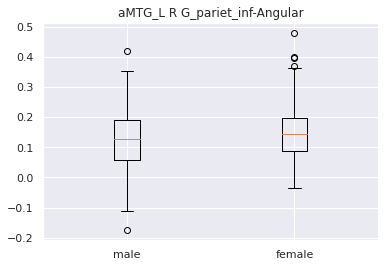

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


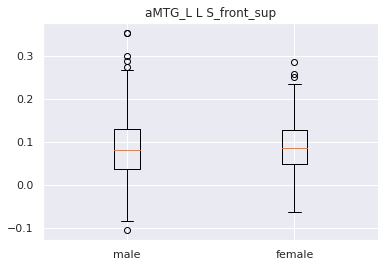

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


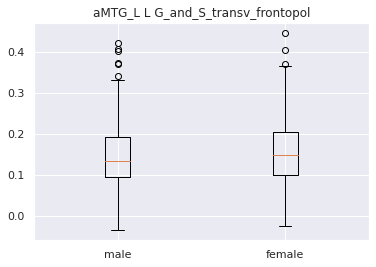

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


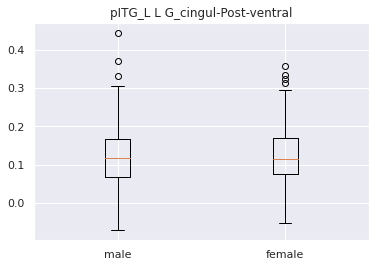

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


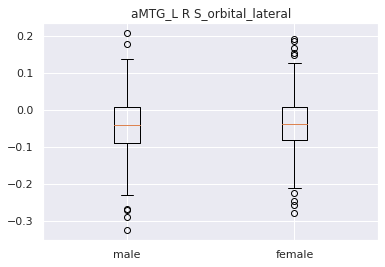

Ttest_indResult(statistic=-1.292465867685566, pvalue=0.1967213906190116)
male mean : -0.042981237
female mean : -0.034570992


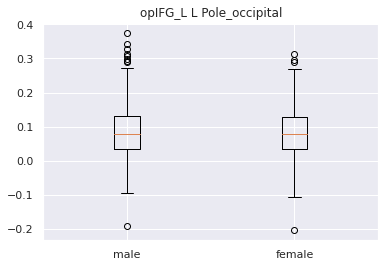

Ttest_indResult(statistic=1.0227015449858845, pvalue=0.30688434881270166)
male mean : 0.08923399
female mean : 0.08254886


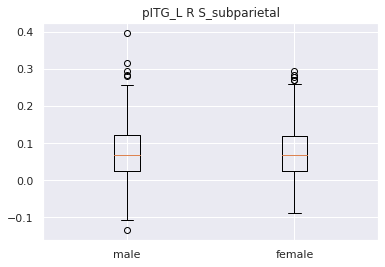

Ttest_indResult(statistic=0.773712472483331, pvalue=0.43942273577180035)
male mean : 0.07773077
female mean : 0.072799556


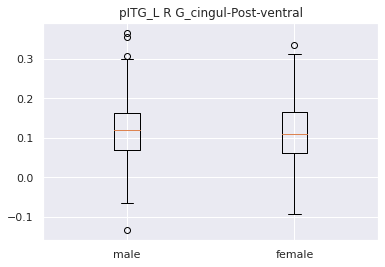

Ttest_indResult(statistic=0.09601695482038536, pvalue=0.9235409730092512)
male mean : 0.11851825
female mean : 0.11792118


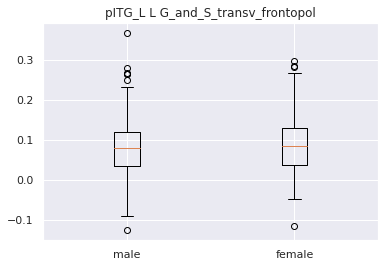

Ttest_indResult(statistic=-0.7998487955908873, pvalue=0.42413278500505813)
male mean : 0.083293684
female mean : 0.08794802


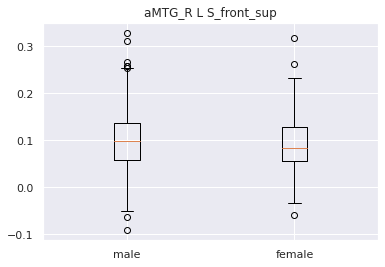

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


In [34]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for aMTG_L

     coefficient    seed                       labels
98      0.159713  aMTG_L       R G_pariet_inf-Angular
78      0.123802  aMTG_L   R G_and_S_transv_frontopol
53      0.117089  aMTG_L                L S_front_sup
4       0.115613  aMTG_L   L G_and_S_transv_frontopol
135     0.098832  aMTG_L          R S_orbital_lateral
112     0.094689  aMTG_L       R Lat_Fis-ant-Horizont
128     0.091343  aMTG_L       R S_interm_prim-Jensen
127     0.082504  aMTG_L                R S_front_sup
55      0.080874  aMTG_L  L S_intrapariet_and_P_trans
74      0.074990  aMTG_L       R G_and_S_frontomargin
The mean accuracy : 0.7447690265486725
The standard deviation of the accuracy : 0.04195740392617605
The lower boundry of the confidance interval of the accuracy : 0.6625325148533674
The upper boundry of the confidance interval of the accuracy : 0.8270055382439776


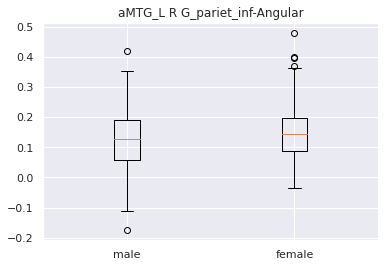

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


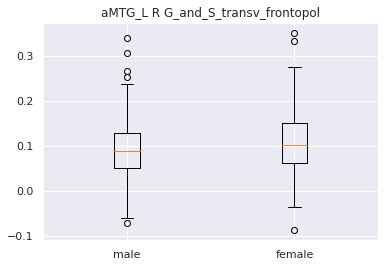

Ttest_indResult(statistic=-2.571148551614975, pvalue=0.010389553654298302)
male mean : 0.09560566
female mean : 0.10965275


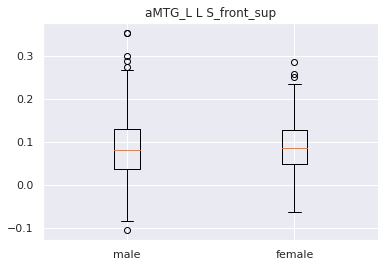

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


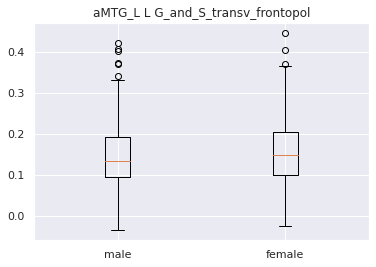

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


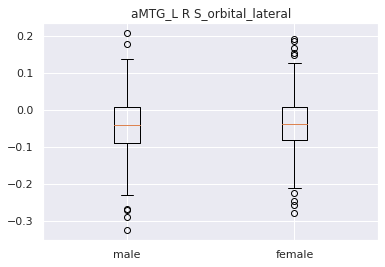

Ttest_indResult(statistic=-1.292465867685566, pvalue=0.1967213906190116)
male mean : -0.042981237
female mean : -0.034570992


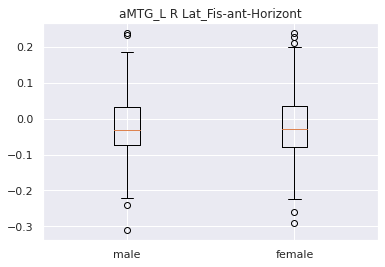

Ttest_indResult(statistic=0.12007247790545271, pvalue=0.9044681925613891)
male mean : -0.022705056
female mean : -0.023588676


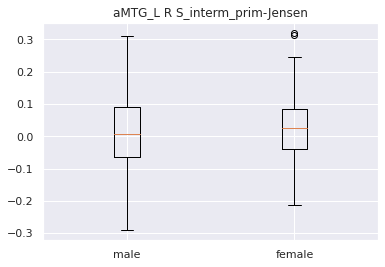

Ttest_indResult(statistic=-1.5294954489961272, pvalue=0.12669836271753415)
male mean : 0.012375309
female mean : 0.025751121


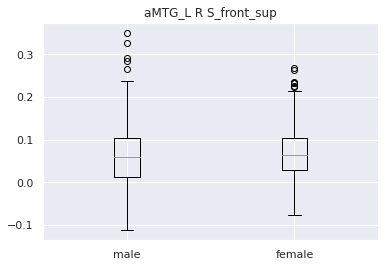

Ttest_indResult(statistic=-1.1389318472140917, pvalue=0.2552116921929824)
male mean : 0.064714245
female mean : 0.07098976


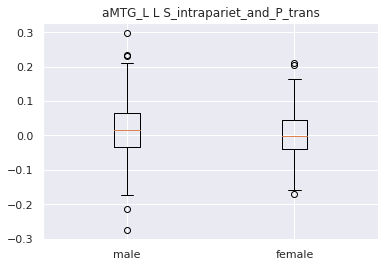

Ttest_indResult(statistic=1.5534617198947105, pvalue=0.1208698513554686)
male mean : 0.014690557
female mean : 0.005323266


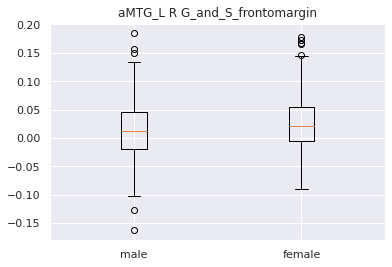

Ttest_indResult(statistic=-2.654234234179124, pvalue=0.008171609968845658)
male mean : 0.015130943
female mean : 0.02619883


In [147]:
rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for aMTG_R

     coefficient    seed                      labels
78      0.106263  aMTG_R  R G_and_S_transv_frontopol
4       0.098402  aMTG_R  L G_and_S_transv_frontopol
98      0.095679  aMTG_R      R G_pariet_inf-Angular
53      0.095088  aMTG_R               L S_front_sup
127     0.089575  aMTG_R               R S_front_sup
135     0.087780  aMTG_R         R S_orbital_lateral
64      0.072560  aMTG_R       L S_parieto_occipital
103     0.069086  aMTG_R               R G_precuneus
112     0.068785  aMTG_R      R Lat_Fis-ant-Horizont
66      0.067331  aMTG_R             L S_postcentral
The mean accuracy : 0.7241982300884955
The standard deviation of the accuracy : 0.04333896457122303
The lower boundry of the confidance interval of the accuracy : 0.6392538595288983
The upper boundry of the confidance interval of the accuracy : 0.8091426006480926


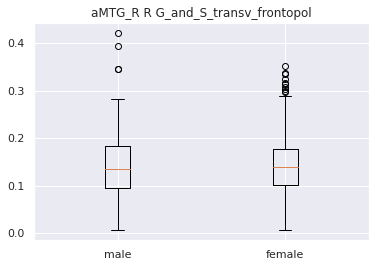

Ttest_indResult(statistic=-0.5021313679136576, pvalue=0.615769711298541)
male mean : 0.14287779
female mean : 0.14569084


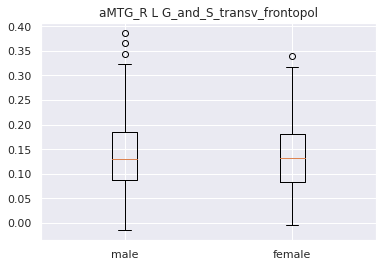

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


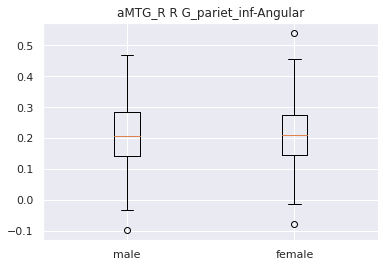

Ttest_indResult(statistic=0.3243155515075406, pvalue=0.7458185428544883)
male mean : 0.21665388
female mean : 0.21397533


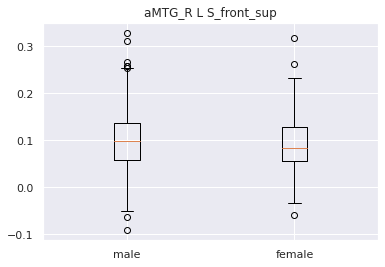

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


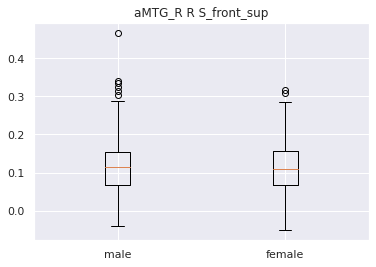

Ttest_indResult(statistic=0.35699531800332124, pvalue=0.7212279003781157)
male mean : 0.116820656
female mean : 0.11475391


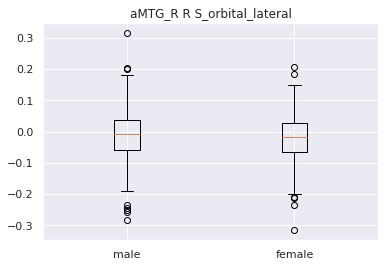

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


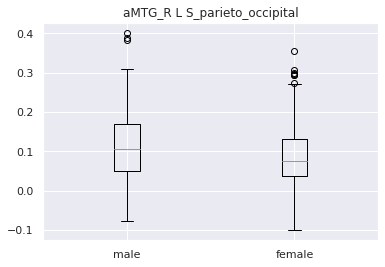

Ttest_indResult(statistic=3.5472737596042614, pvalue=0.0004213927704471286)
male mean : 0.112914845
female mean : 0.08894315


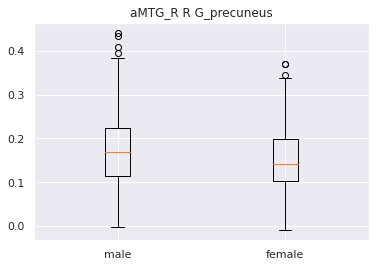

Ttest_indResult(statistic=3.145357117857211, pvalue=0.001745610206025575)
male mean : 0.17314157
female mean : 0.15322492


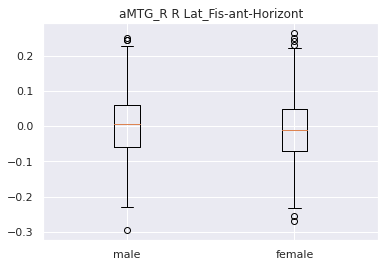

Ttest_indResult(statistic=2.1749926651334737, pvalue=0.030042475203811723)
male mean : 0.0059737926
female mean : -0.011033725


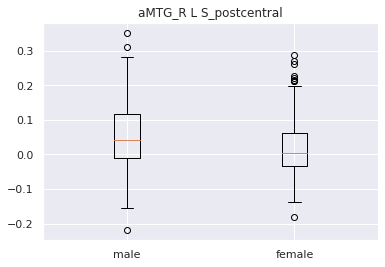

Ttest_indResult(statistic=4.322259791116856, pvalue=1.823637503842923e-05)
male mean : 0.04981075
female mean : 0.01834556


In [149]:
rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for opIFG_L

     coefficient     seed                     labels
41      0.108705  opIFG_L           L Pole_occipital
1       0.077864  opIFG_L    L G_and_S_occipital_inf
20      0.074842  opIFG_L    L G_oc-temp_lat-fusifor
124     0.069782  opIFG_L     R S_collat_transv_post
50      0.068693  opIFG_L     L S_collat_transv_post
115     0.066168  opIFG_L           R Pole_occipital
56      0.062111  opIFG_L  L S_oc_middle_and_Lunatus
40      0.061862  opIFG_L             L Lat_Fis-post
21      0.061012  opIFG_L    L G_oc-temp_med-Lingual
43      0.060960  opIFG_L              L S_calcarine
The mean accuracy : 0.7548345132743363
The standard deviation of the accuracy : 0.04075594162983533
The lower boundry of the confidance interval of the accuracy : 0.6749528676798591
The upper boundry of the confidance interval of the accuracy : 0.8347161588688135


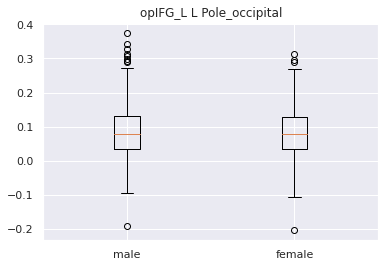

Ttest_indResult(statistic=1.0227015449858845, pvalue=0.30688434881270166)
male mean : 0.08923399
female mean : 0.08254886


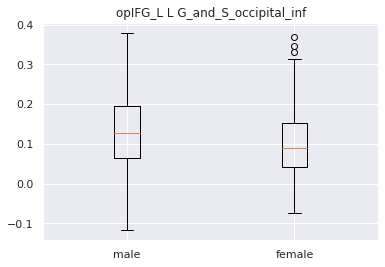

Ttest_indResult(statistic=4.290902217129095, pvalue=2.091808235930295e-05)
male mean : 0.13385779
female mean : 0.1019564


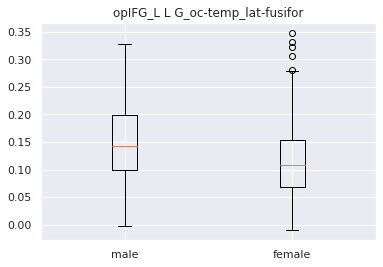

Ttest_indResult(statistic=5.8491198530470045, pvalue=8.347799493217066e-09)
male mean : 0.14884304
female mean : 0.116547726


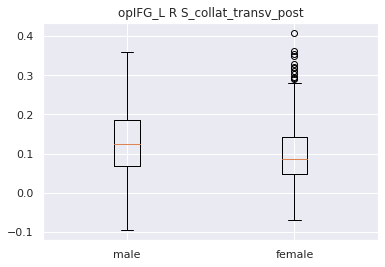

Ttest_indResult(statistic=4.2835846567255205, pvalue=2.159598690473479e-05)
male mean : 0.12967476
female mean : 0.099663146


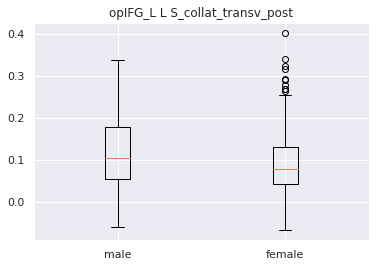

Ttest_indResult(statistic=4.270024840833031, pvalue=2.2907984017195004e-05)
male mean : 0.12016607
female mean : 0.09215127


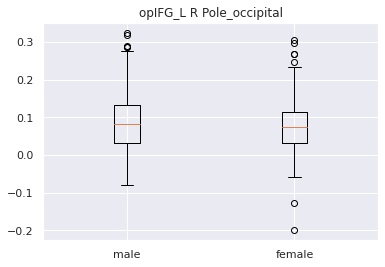

Ttest_indResult(statistic=1.7907080350361146, pvalue=0.07387255978359172)
male mean : 0.08912083
female mean : 0.07786428


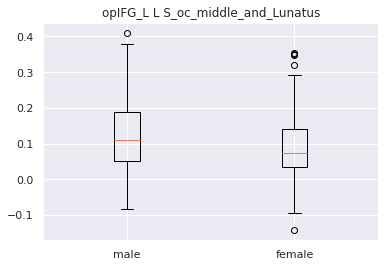

Ttest_indResult(statistic=3.9593194133662495, pvalue=8.470750162521169e-05)
male mean : 0.11901468
female mean : 0.08859685


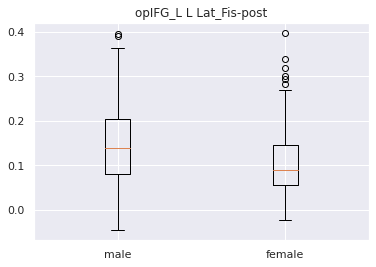

Ttest_indResult(statistic=6.364933392751482, pvalue=4.029331087681434e-10)
male mean : 0.14507884
female mean : 0.104537904


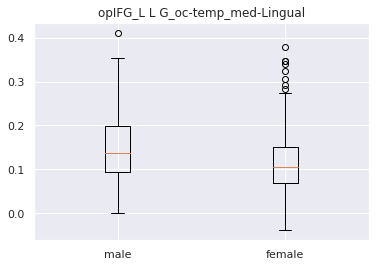

Ttest_indResult(statistic=5.321141269866611, pvalue=1.4862396535701113e-07)
male mean : 0.14772123
female mean : 0.11525328


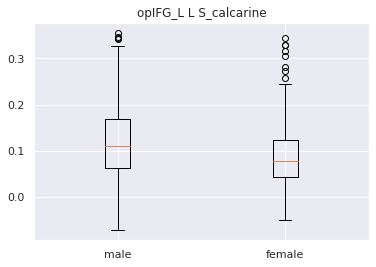

Ttest_indResult(statistic=4.997508247569585, pvalue=7.745382660488108e-07)
male mean : 0.12062381
female mean : 0.0899793


In [151]:
rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for opIFG_R

     coefficient     seed                       labels
41      0.082350  opIFG_R             L Pole_occipital
125     0.079847  opIFG_R                R S_front_inf
43      0.078646  opIFG_R                L S_calcarine
60      0.075013  opIFG_R  L S_oc-temp_med_and_Lingual
20      0.074168  opIFG_R      L G_oc-temp_lat-fusifor
21      0.073179  opIFG_R      L G_oc-temp_med-Lingual
121     0.072690  opIFG_R      R S_circular_insula_inf
47      0.069182  opIFG_R      L S_circular_insula_inf
90      0.068517  opIFG_R    R G_Ins_lg_and_S_cent_ins
63      0.064658  opIFG_R         L S_orbital-H_Shaped
The mean accuracy : 0.748191150442478
The standard deviation of the accuracy : 0.04156195480724132
The lower boundry of the confidance interval of the accuracy : 0.666729719020285
The upper boundry of the confidance interval of the accuracy : 0.829652581864671


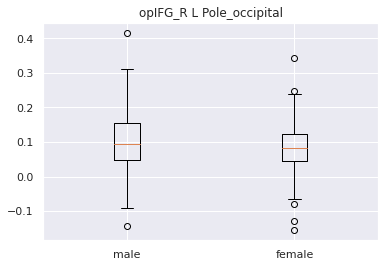

Ttest_indResult(statistic=2.8938857514023053, pvalue=0.0039511454822068635)
male mean : 0.104489796
female mean : 0.086915694


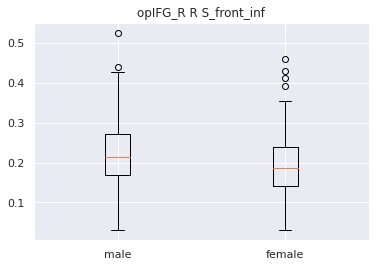

Ttest_indResult(statistic=5.115644829965803, pvalue=4.282989746232668e-07)
male mean : 0.2219755
female mean : 0.1895739


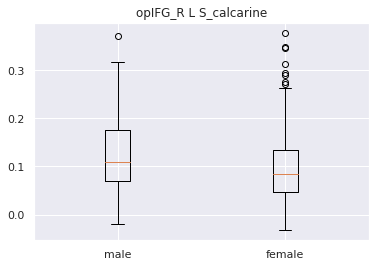

Ttest_indResult(statistic=4.630155240390032, pvalue=4.532821865417859e-06)
male mean : 0.12374703
female mean : 0.09596405


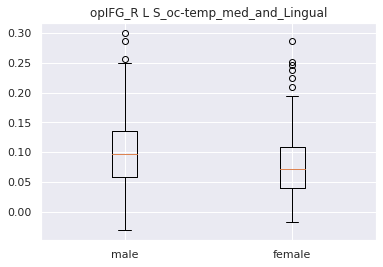

Ttest_indResult(statistic=4.827321505738625, pvalue=1.7812051723580022e-06)
male mean : 0.10082634
female mean : 0.07872187


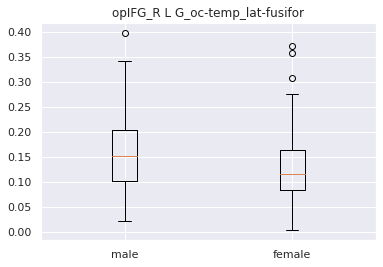

Ttest_indResult(statistic=5.732376818088248, pvalue=1.609202883985806e-08)
male mean : 0.1562101
female mean : 0.12528288


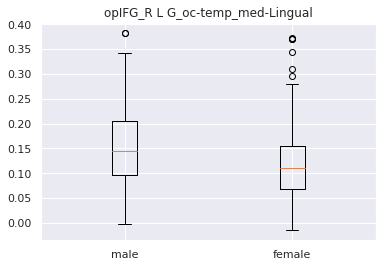

Ttest_indResult(statistic=5.3967280980247985, pvalue=9.980979286711935e-08)
male mean : 0.15296073
female mean : 0.12062115


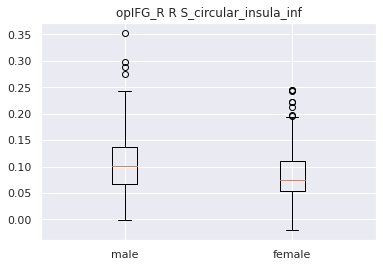

Ttest_indResult(statistic=5.226547983016146, pvalue=2.429845275450505e-07)
male mean : 0.10671159
female mean : 0.08417532


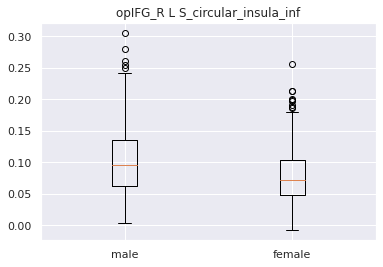

Ttest_indResult(statistic=5.209214471386057, pvalue=2.656732376950302e-07)
male mean : 0.10079068
female mean : 0.079217285


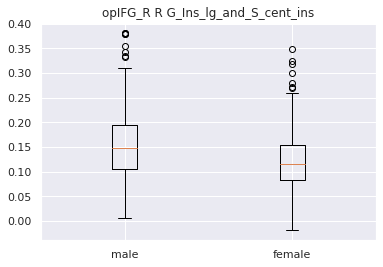

Ttest_indResult(statistic=5.739625655933474, pvalue=1.545440086293778e-08)
male mean : 0.15487437
female mean : 0.12380144


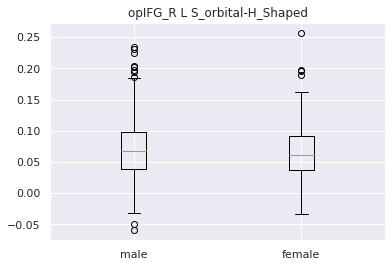

Ttest_indResult(statistic=1.5933715057876494, pvalue=0.11163316543864758)
male mean : 0.07277564
female mean : 0.06657463


In [153]:
rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for pITG_L

     coefficient    seed                       labels
9       0.128056  pITG_L      L G_cingul-Post-ventral
83      0.113791  pITG_L      R G_cingul-Post-ventral
26      0.106214  pITG_L             L G_parietal_sup
55      0.102836  pITG_L  L S_intrapariet_and_P_trans
4       0.100840  pITG_L   L G_and_S_transv_frontopol
115     0.095398  pITG_L             R Pole_occipital
86      0.087411  pITG_L        R G_front_inf-Orbital
41      0.081074  pITG_L             L Pole_occipital
66      0.080110  pITG_L              L S_postcentral
135     0.079319  pITG_L          R S_orbital_lateral
The mean accuracy : 0.7250424778761062
The standard deviation of the accuracy : 0.04288747208640963
The lower boundry of the confidance interval of the accuracy : 0.6409830325867434
The upper boundry of the confidance interval of the accuracy : 0.809101923165469


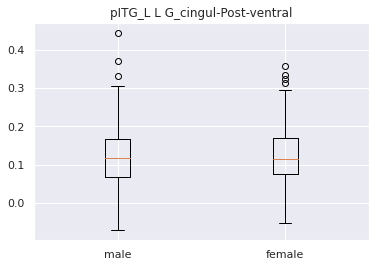

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


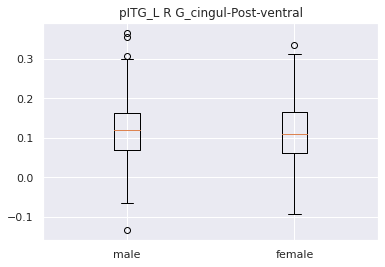

Ttest_indResult(statistic=0.09601695482038536, pvalue=0.9235409730092512)
male mean : 0.11851825
female mean : 0.11792118


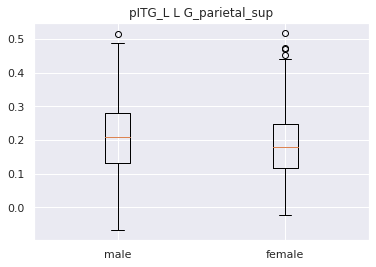

Ttest_indResult(statistic=2.776333935754648, pvalue=0.005678904619509242)
male mean : 0.21009725
female mean : 0.18630977


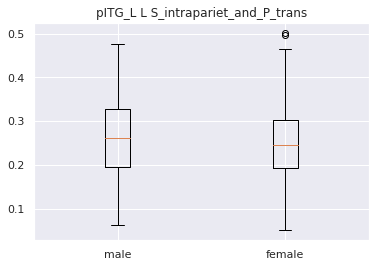

Ttest_indResult(statistic=2.210150284070341, pvalue=0.027492662382419545)
male mean : 0.2640814
female mean : 0.24852245


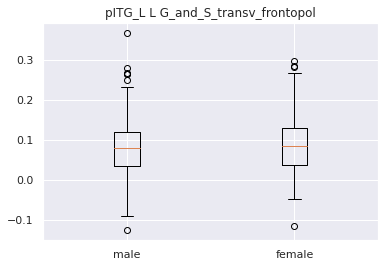

Ttest_indResult(statistic=-0.7998487955908873, pvalue=0.42413278500505813)
male mean : 0.083293684
female mean : 0.08794802


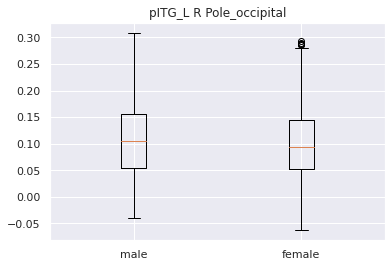

Ttest_indResult(statistic=1.39165171012916, pvalue=0.1645726291539082)
male mean : 0.11096361
female mean : 0.10281154


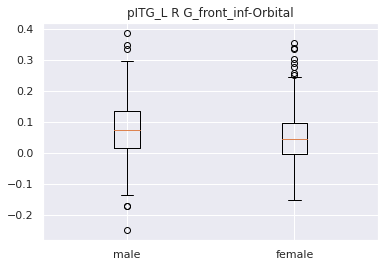

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


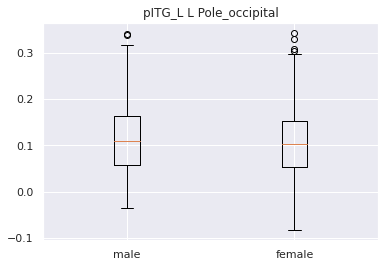

Ttest_indResult(statistic=1.2751197640641383, pvalue=0.2027881653656923)
male mean : 0.11626018
female mean : 0.10826992


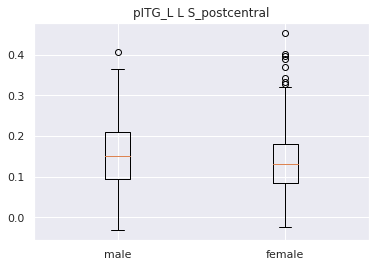

Ttest_indResult(statistic=2.5890681056057545, pvalue=0.009870223882467003)
male mean : 0.15819883
female mean : 0.14057475


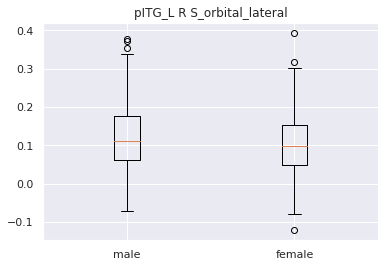

Ttest_indResult(statistic=2.495971670981116, pvalue=0.012843712198704553)
male mean : 0.11944816
female mean : 0.10241498


In [155]:
rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for pITG_R

     coefficient    seed                   labels
20      0.116365  pITG_R  L G_oc-temp_lat-fusifor
41      0.096079  pITG_R         L Pole_occipital
83      0.093142  pITG_R  R G_cingul-Post-ventral
125     0.089565  pITG_R            R S_front_inf
84      0.079409  pITG_R               R G_cuneus
9       0.071207  pITG_R  L G_cingul-Post-ventral
59      0.070110  pITG_R          L S_oc-temp_lat
21      0.067775  pITG_R  L G_oc-temp_med-Lingual
115     0.062380  pITG_R         R Pole_occipital
66      0.062090  pITG_R          L S_postcentral
The mean accuracy : 0.7271796460176991
The standard deviation of the accuracy : 0.04261735609637595
The lower boundry of the confidance interval of the accuracy : 0.6436496280688022
The upper boundry of the confidance interval of the accuracy : 0.810709663966596


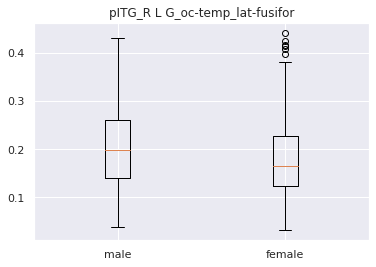

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


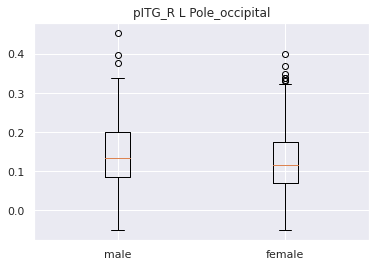

Ttest_indResult(statistic=2.1544399741091187, pvalue=0.03162548851303502)
male mean : 0.14234442
female mean : 0.12738003


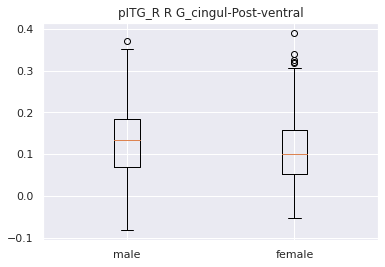

Ttest_indResult(statistic=2.7984808337835725, pvalue=0.0053086933505674845)
male mean : 0.1303599
female mean : 0.110936716


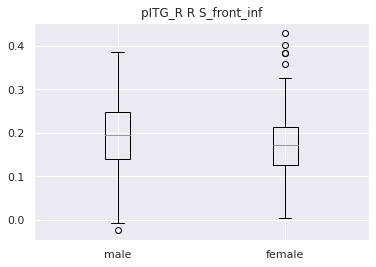

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


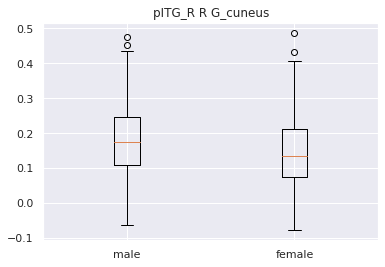

Ttest_indResult(statistic=3.905515094980048, pvalue=0.00010533315735719154)
male mean : 0.18062297
female mean : 0.14835264


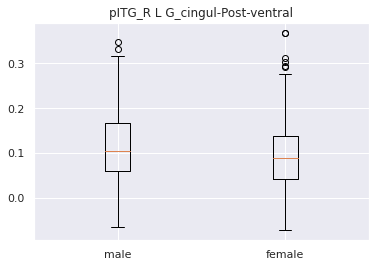

Ttest_indResult(statistic=2.8713090107584436, pvalue=0.004240238016901831)
male mean : 0.11182308
female mean : 0.092711404


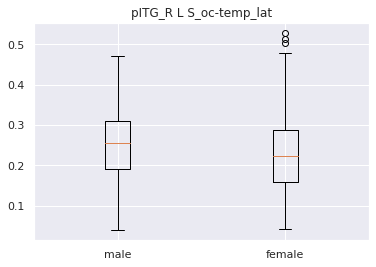

Ttest_indResult(statistic=3.5098086157758033, pvalue=0.0004839877452465248)
male mean : 0.2529133
female mean : 0.22639872


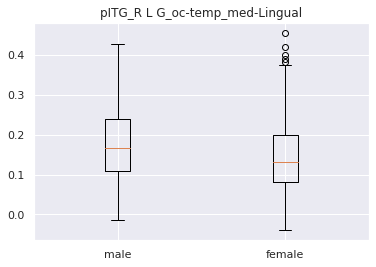

Ttest_indResult(statistic=4.202136263805384, pvalue=3.070337181756022e-05)
male mean : 0.17783917
female mean : 0.1470981


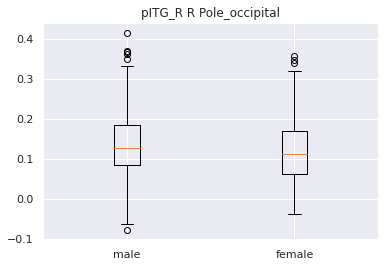

Ttest_indResult(statistic=2.708058425442263, pvalue=0.006971735137557166)
male mean : 0.13952155
female mean : 0.12151752


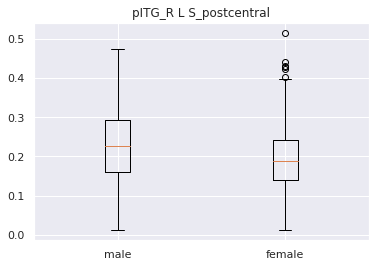

Ttest_indResult(statistic=4.500613935739143, pvalue=8.223189970303467e-06)
male mean : 0.22811967
female mean : 0.19511805


In [157]:
rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for planumtemp_L

     coefficient          seed                       labels
60      0.109682  planumtemp_L  L S_oc-temp_med_and_Lingual
20      0.106381  planumtemp_L      L G_oc-temp_lat-fusifor
43      0.102335  planumtemp_L                L S_calcarine
21      0.101442  planumtemp_L      L G_oc-temp_med-Lingual
124     0.100413  planumtemp_L       R S_collat_transv_post
94      0.094914  planumtemp_L      R G_oc-temp_lat-fusifor
95      0.078575  planumtemp_L      R G_oc-temp_med-Lingual
50      0.073690  planumtemp_L       L S_collat_transv_post
84      0.067802  planumtemp_L                   R G_cuneus
16      0.066221  planumtemp_L    L G_Ins_lg_and_S_cent_ins
The mean accuracy : 0.7298070796460177
The standard deviation of the accuracy : 0.04224918968796545
The lower boundry of the confidance interval of the accuracy : 0.6469986678576054
The upper boundry of the confidance interval of the accuracy : 0.8126154914344299


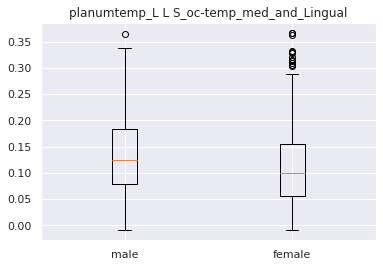

Ttest_indResult(statistic=3.020211908506582, pvalue=0.002639537757200332)
male mean : 0.13396002
female mean : 0.11491338


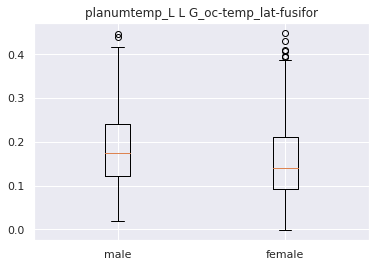

Ttest_indResult(statistic=3.884599647610934, pvalue=0.00011456706619806536)
male mean : 0.18645073
female mean : 0.1582872


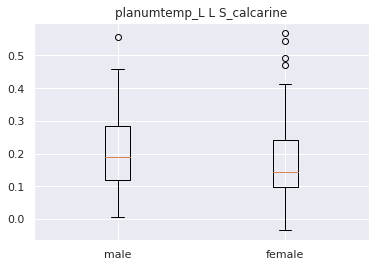

Ttest_indResult(statistic=3.6505599712750856, pvalue=0.0002858230530319466)
male mean : 0.20659167
female mean : 0.17391653


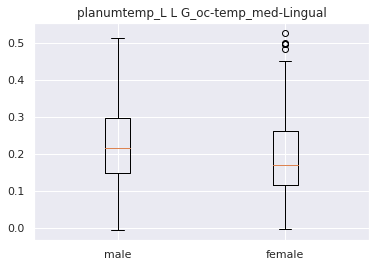

Ttest_indResult(statistic=3.7312157259175804, pvalue=0.00020971058206866478)
male mean : 0.22793445
female mean : 0.1945707


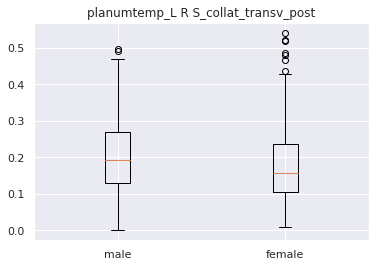

Ttest_indResult(statistic=2.8078444407827665, pvalue=0.0051588520422414215)
male mean : 0.20265692
female mean : 0.17838421


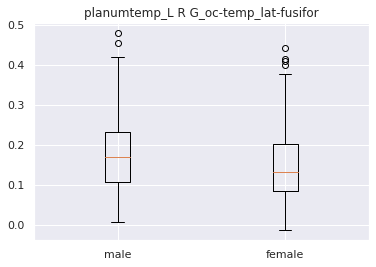

Ttest_indResult(statistic=3.844351881138195, pvalue=0.000134530254843104)
male mean : 0.17783996
female mean : 0.14997594


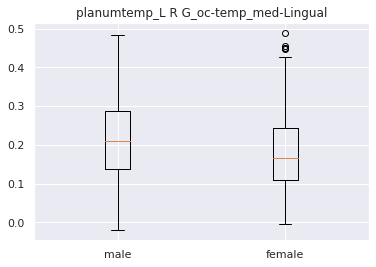

Ttest_indResult(statistic=3.9401536556181798, pvalue=9.157157832593854e-05)
male mean : 0.21691808
female mean : 0.18325616


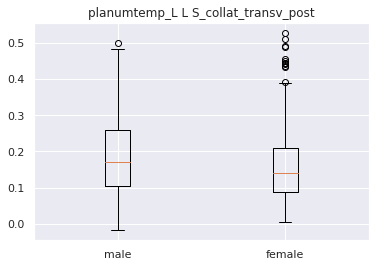

Ttest_indResult(statistic=3.0011479430352437, pvalue=0.0028077474666258415)
male mean : 0.18676466
female mean : 0.16102566


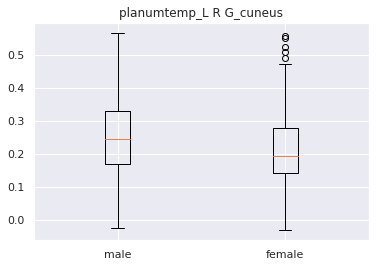

Ttest_indResult(statistic=3.786412691483393, pvalue=0.000169108074810519)
male mean : 0.25222728
female mean : 0.21697903


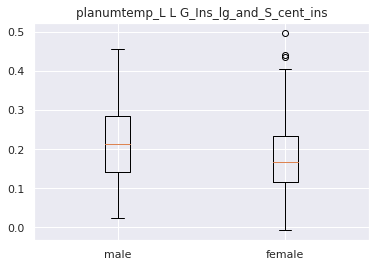

Ttest_indResult(statistic=4.7473737697537555, pvalue=2.611760766602863e-06)
male mean : 0.21818782
female mean : 0.18234089


In [159]:
rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for planumtemp_R

     coefficient          seed                       labels
43      0.109145  planumtemp_R                L S_calcarine
72      0.095892  planumtemp_R             L S_temporal_sup
60      0.094791  planumtemp_R  L S_oc-temp_med_and_Lingual
20      0.082885  planumtemp_R      L G_oc-temp_lat-fusifor
47      0.072129  planumtemp_R      L S_circular_insula_inf
21      0.069142  planumtemp_R      L G_oc-temp_med-Lingual
94      0.068069  planumtemp_R      R G_oc-temp_lat-fusifor
121     0.065162  planumtemp_R      R S_circular_insula_inf
108     0.062114  planumtemp_R      R G_temp_sup-Plan_polar
78      0.061713  planumtemp_R   R G_and_S_transv_frontopol
The mean accuracy : 0.7170070796460177
The standard deviation of the accuracy : 0.042554433922956256
The lower boundry of the confidance interval of the accuracy : 0.6336003891570234
The upper boundry of the confidance interval of the accuracy : 0.800413770135012


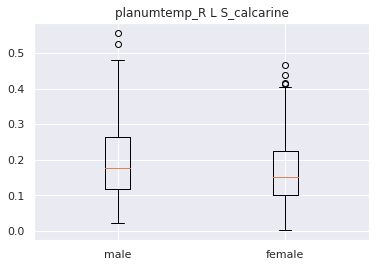

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


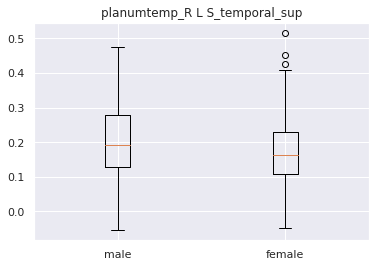

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676


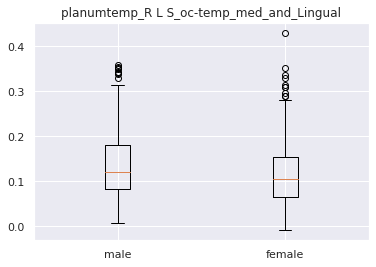

Ttest_indResult(statistic=3.0624233052403027, pvalue=0.00229945814708059)
male mean : 0.13526098
female mean : 0.116651125


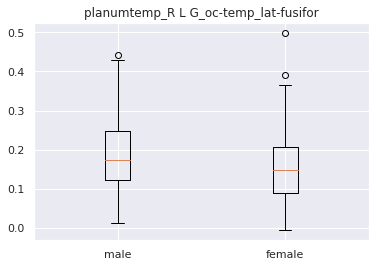

Ttest_indResult(statistic=4.196349599946236, pvalue=3.147371906718927e-05)
male mean : 0.18705179
female mean : 0.15669796


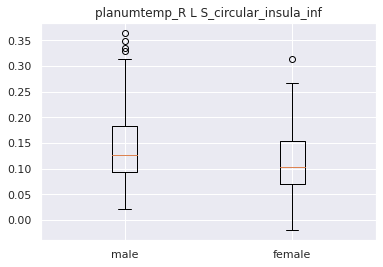

Ttest_indResult(statistic=5.007456260267843, pvalue=7.371794588395764e-07)
male mean : 0.14035343
female mean : 0.11432696


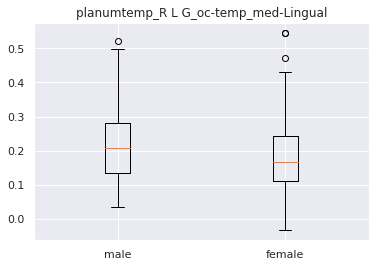

Ttest_indResult(statistic=4.142846816078422, pvalue=3.9523455590138634e-05)
male mean : 0.21708734
female mean : 0.18176907


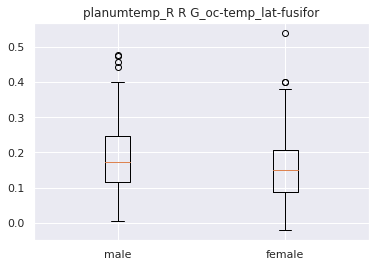

Ttest_indResult(statistic=4.001262735967014, pvalue=7.134805052761894e-05)
male mean : 0.18411116
female mean : 0.15461634


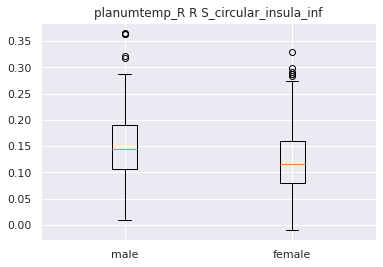

Ttest_indResult(statistic=5.1698335247619145, pvalue=3.2510555654335486e-07)
male mean : 0.15255034
female mean : 0.12557979


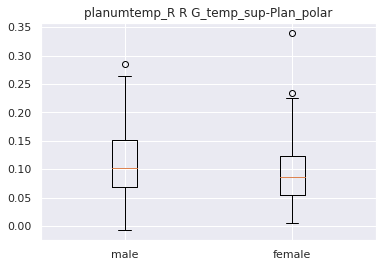

Ttest_indResult(statistic=3.672343154381283, pvalue=0.0002630403504360859)
male mean : 0.111256644
female mean : 0.09470312


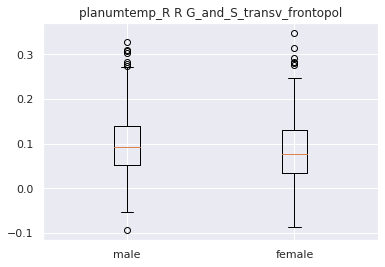

Ttest_indResult(statistic=2.4450835297243194, pvalue=0.014784556396720787)
male mean : 0.09999801
female mean : 0.084834725


In [161]:
rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for all seed left

     coefficient     seed                      labels
394     0.128692   aMTG_L      R G_pariet_inf-Angular
349     0.100982   aMTG_L               L S_front_sup
300     0.092799   aMTG_L  L G_and_S_transv_frontopol
453     0.085000   pITG_L     L G_cingul-Post-ventral
374     0.082559   aMTG_L  R G_and_S_transv_frontopol
408     0.079315   aMTG_L      R Lat_Fis-ant-Horizont
41      0.076981  opIFG_L            L Pole_occipital
431     0.076852   aMTG_L         R S_orbital_lateral
527     0.076444   pITG_L     R G_cingul-Post-ventral
448     0.072345   pITG_L  L G_and_S_transv_frontopol
The mean accuracy : 0.85109203539823
The standard deviation of the accuracy : 0.03469989531321699
The lower boundry of the confidance interval of the accuracy : 0.7830802405843247
The upper boundry of the confidance interval of the accuracy : 0.9191038302121353


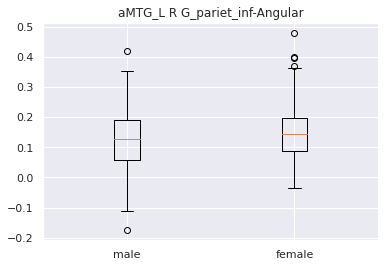

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


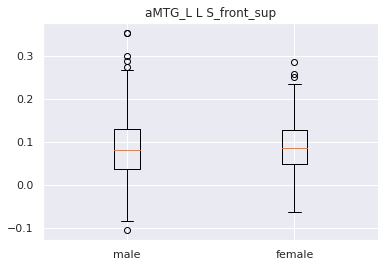

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


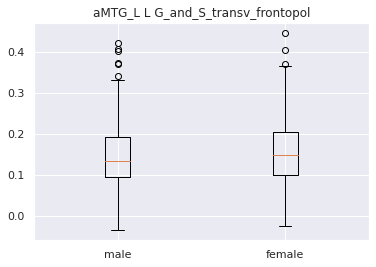

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


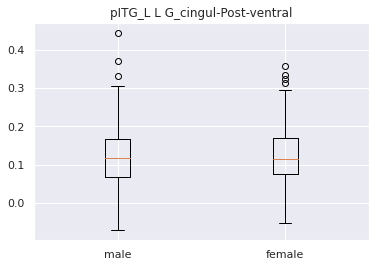

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


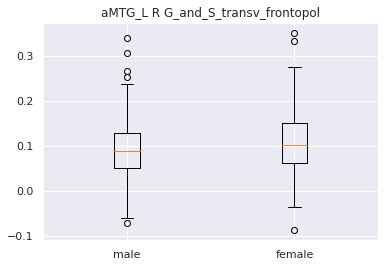

Ttest_indResult(statistic=-2.571148551614975, pvalue=0.010389553654298302)
male mean : 0.09560566
female mean : 0.10965275


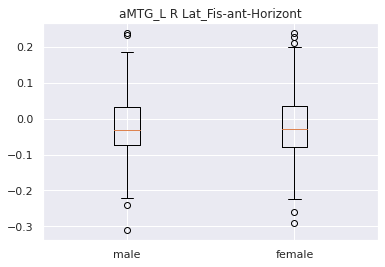

Ttest_indResult(statistic=0.12007247790545271, pvalue=0.9044681925613891)
male mean : -0.022705056
female mean : -0.023588676


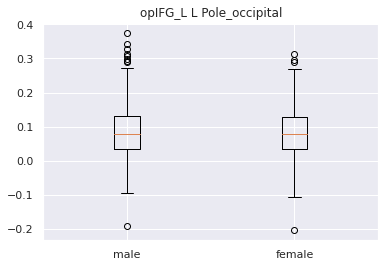

Ttest_indResult(statistic=1.0227015449858845, pvalue=0.30688434881270166)
male mean : 0.08923399
female mean : 0.08254886


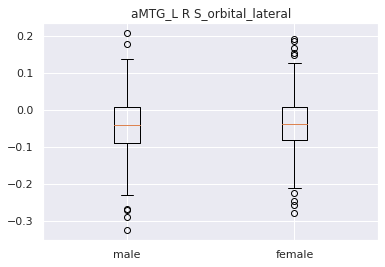

Ttest_indResult(statistic=-1.292465867685566, pvalue=0.1967213906190116)
male mean : -0.042981237
female mean : -0.034570992


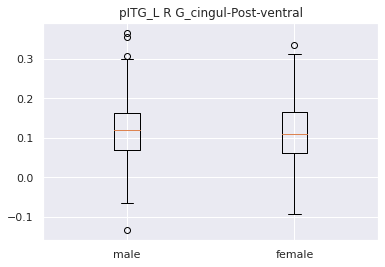

Ttest_indResult(statistic=0.09601695482038536, pvalue=0.9235409730092512)
male mean : 0.11851825
female mean : 0.11792118


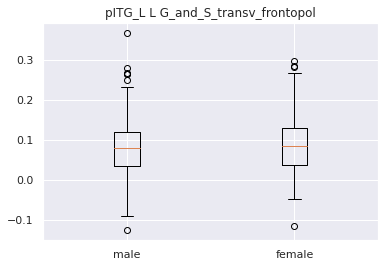

Ttest_indResult(statistic=-0.7998487955908873, pvalue=0.42413278500505813)
male mean : 0.083293684
female mean : 0.08794802


In [163]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

## Best region for all seed right

     coefficient          seed                      labels
349     0.088181        aMTG_R               L S_front_sup
464     0.082823        pITG_R     L G_oc-temp_lat-fusifor
423     0.079728        aMTG_R               R S_front_sup
485     0.078090        pITG_R            L Pole_occipital
569     0.077108        pITG_R               R S_front_inf
431     0.076072        aMTG_R         R S_orbital_lateral
191     0.074937  planumtemp_R               L S_calcarine
300     0.073700        aMTG_R  L G_and_S_transv_frontopol
374     0.069628        aMTG_R  R G_and_S_transv_frontopol
220     0.067752  planumtemp_R            L S_temporal_sup
The mean accuracy : 0.8264513274336283
The standard deviation of the accuracy : 0.03755704565435549
The lower boundry of the confidance interval of the accuracy : 0.7528395179510915
The upper boundry of the confidance interval of the accuracy : 0.900063136916165


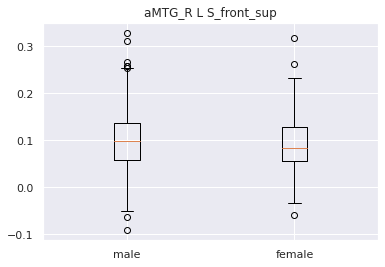

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


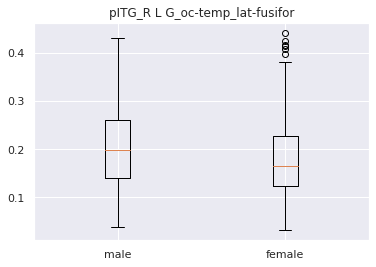

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


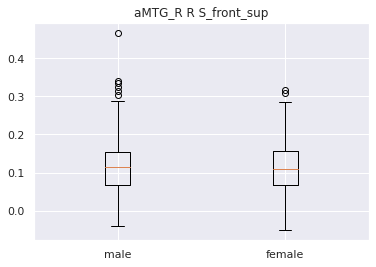

Ttest_indResult(statistic=0.35699531800332124, pvalue=0.7212279003781157)
male mean : 0.116820656
female mean : 0.11475391


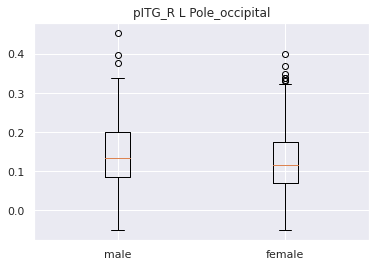

Ttest_indResult(statistic=2.1544399741091187, pvalue=0.03162548851303502)
male mean : 0.14234442
female mean : 0.12738003


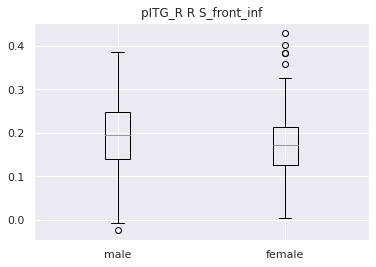

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


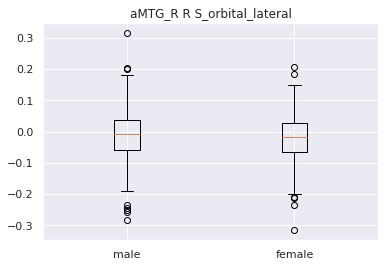

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


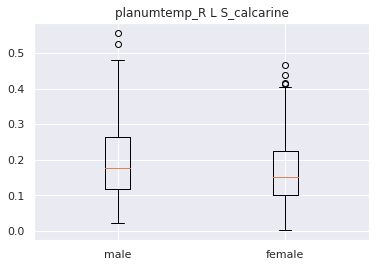

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


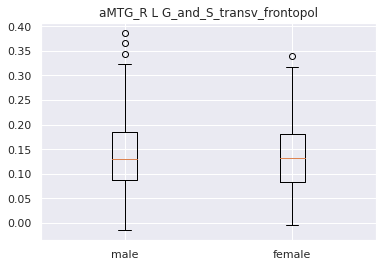

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


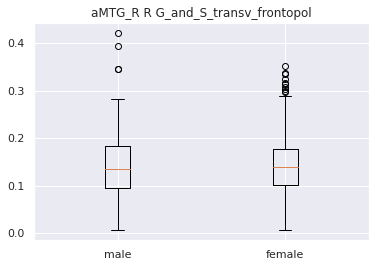

Ttest_indResult(statistic=-0.5021313679136576, pvalue=0.615769711298541)
male mean : 0.14287779
female mean : 0.14569084


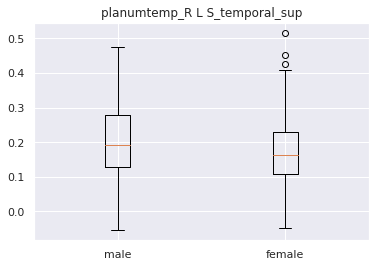

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676


In [165]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results_logi["acc_test"], pvalue_logi, moyenne_logi, rois, label, run_logi)
bestRegion(ROIs)

# Correlation between resting state

In [96]:
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl_REST1LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST1RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1RL_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST2LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"

Final_df["subject_label"]
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

for seed in SEEDS:
    corr_1LR_1RL = []
    corr_1LR_2LR = []
    corr_1LR_2RL = []
    corr_1RL_2LR = []
    corr_1RL_2RL = []
    corr_2LR_2RL = []
    rest1LR = []
    rest1RL = []
    rest2LR = []
    rest2RL = []
    
    rest1LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest1RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
        
    for j in range(0, len(rest1LR[0])):
        corr_1LR_1RL.append(np.corrcoef(rest1LR[0][j], rest1RL[0][j])[0][1])
        corr_1LR_2LR.append(np.corrcoef(rest1LR[0][j], rest2LR[0][j])[0][1])
        corr_1LR_2RL.append(np.corrcoef(rest1LR[0][j], rest2RL[0][j])[0][1])
        corr_1RL_2LR.append(np.corrcoef(rest1RL[0][j], rest2LR[0][j])[0][1])
        corr_1RL_2RL.append(np.corrcoef(rest1RL[0][j], rest2RL[0][j])[0][1])
        corr_2LR_2RL.append(np.corrcoef(rest2LR[0][j], rest2RL[0][j])[0][1])
        
        
    print(seed)
    print("rest1LR and rest1RL")
    print("mean : " + str(np.mean(corr_1LR_1RL)))
    print("min : " + str(min(corr_1LR_1RL)))
    print("max : " + str(max(corr_1LR_1RL)))
    print("\n")
    print("rest1LR and rest2LR")
    print("mean : " + str(np.mean(corr_1LR_2LR)))
    print("min : " + str(min(corr_1LR_2LR)))
    print("max : " + str(max(corr_1LR_2LR)))
    print("\n")
    print("rest1LR and rest2RL")
    print("mean : " + str(np.mean(corr_1LR_2RL)))
    print("min : " + str(min(corr_1LR_2RL)))
    print("max : " + str(max(corr_1LR_2RL)))
    print("\n")
    print("rest1RL and rest2LR")
    print("mean : " + str(np.mean(corr_1RL_2LR)))
    print("min : " + str(min(corr_1RL_2LR)))
    print("max : " + str(max(corr_1RL_2LR)))
    print("\n")
    print("rest1RL and rest2RL")
    print("mean : " + str(np.mean(corr_1RL_2RL)))
    print("min : " + str(min(corr_1RL_2RL)))
    print("max : " + str(max(corr_1RL_2RL)))
    print("\n")
    print("rest2LR and rest2RL")
    print("mean : " + str(np.mean(corr_2LR_2RL)))
    print("min : " + str(min(corr_2LR_2RL)))
    print("max : " + str(max(corr_2LR_2RL)))
    print("\n")
    print("\n")

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


opIFG_L
rest1LR and rest1RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest1LR and rest2LR
mean : 0.7698490941301699
min : 0.1018440521993477
max : 0.9586093500051478


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7750584728732756
min : 0.05147001936993981
max : 0.9511524080813849


rest1RL and rest2RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest2LR and rest2RL
mean : 0.7698490941301698
min : 0.10184405219934768
max : 0.9586093500051476




planumtemp_L
rest1LR and rest1RL
mean : 0.7885160499127559
min : 0.11528407305428233
max : 0.9650591348987411


rest1LR and rest2LR
mean : 0.7693670776944767
min : 0.12378670509244566
max : 0.970730776939474


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7611741204293923
min : 0.05853655064429218
max : 0.9535431025556377


rest1RL and rest2RL
mean : 0.7885160499127559
min :

# Test model on shuffled data

In [14]:
 ## a faire pour projet 2

# Noise testing

In [ ]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-all_mean_LinearSVC.pkl"

results = joblib.load(results_path_all_seed)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)

In [7]:
data_results

len_X_train  len_X_test                 score  \
0             451         113  [0.9134782608695652]   
1             451         113  [0.9135748792270532]   
2             451         113  [0.9158454106280194]   
3             451         113  [0.8957004830917874]   
4             451         113  [0.9180193236714975]   
...           ...         ...                   ...   
9995          451         113  [0.9048792270531401]   
9996          451         113  [0.8867632850241547]   
9997          451         113  [0.9334782608695653]   
9998          451         113  [0.8867632850241547]   
9999          451         113  [0.9156038647342996]   

                                       confusion_matrix  acc_test  acc_train  \
0     predicted class  Femme  Homme
actual class    ...  0.911504        1.0   
1     predicted class  Femme  Homme
actual class    ...  0.973451        1.0   
2     predicted class  Femme  Homme
actual class    ...  0.938053        1.0   
3     predicted class  Femme  Homme
actual class    ...  0.893805        1.0   
4     predicted class  Femme  Homme
actual class    ...  0.929204        1.0   
...                                                 ...       ...        ...   
9995  predicted class  Femme  Homme
actual class    ...  0.938053        1.0   
9996  predicted class  Femme  Homme
actual class    ...  0.964602        1.0   
9997  predicted class  Femme  Homme
actual class    ...  0.929204        1.0   
9998  predicted class  Femme  Homme
actual class    ...  0.920354        1.0   
9999  predicted class  Femme  Homme
actual class    ...  0.902655        1.0   

                          model  
0     LinearSVC(max_iter=10000)  
1     LinearSVC(max_iter=10000)  
2     LinearSVC(max_iter=10000)  
3     LinearSVC(max_iter=10000)  
4     LinearSVC(max_iter=10000)  
...                         ...  
9995  LinearSVC(max_iter=10000)  
9996  LinearSVC(max_iter=10000)  
9997  LinearSVC(max_iter=10000)  
9998  LinearSVC(max_iter=10000)  
9999  LinearSVC(max_iter=10000)  

[10000 rows x 7 columns]

In [25]:
x_correl = []
for sub in tqdm(df_boot["subject_label"]):
    line_temp = []
    for seed in SEEDS:
        line_temp.append(data[(sub, seed)])
    x_correl.append(np.concatenate(line_temp))
x_correl = np.array(x_correl)


model = data_results

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 144090.72it/s]


In [62]:
acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

(0.4, 1.0)

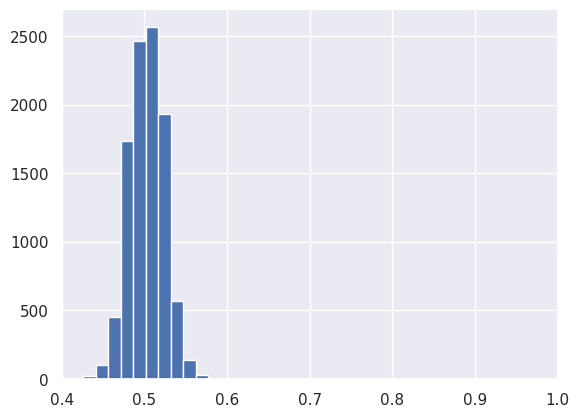

In [66]:
plt.hist(acc_iter)
plt.xlim([0.4, 1])

In [67]:
acc_iter.mean()

0.5030143859649122



results_path_aMTG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_R_mean_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_L_mean_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_R_mean_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_L_mean_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_R_mean_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_L_mean_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_R_mean_LinearSVC.pkl"
results_path_all_left = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-left_mean_LinearSVC.pkl"
results_path_all_right = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-right_mean_LinearSVC.pkl"


In [ ]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_aMTG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_L_mean_LinearSVC.pkl"

results = joblib.load(results_path_aMTG_L)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)


acc_iter = []
model_test = data_results["model"][random.randint(0, 10000)]
for i in range(0, 10000):
    gender_test = np.asarray(df_boot["Gender"])
    np.random.shuffle(gender_test)
    acc_rand = model_test.score(x_correl, gender_test)
    acc_iter.append(acc_rand)
    
acc_iter = np.asarray(acc_iter)

plt.hist(acc_iter)
plt.xlim([0.4, 1])

#

## 